In [51]:
import pennylane as qml
from pennylane import numpy as np

from tqdm import tqdm
from IPython.display import clear_output

import torch
from torch.autograd import Variable
from torchvision import datasets, transforms
import cv2
from functools import reduce
import pickle
import pandas as pd

In [267]:
from torchvision import datasets, transforms
# 1. 데이터 불러오기
train_data = datasets.MNIST(root='./data/02/', train=True, download=True)
test_data = datasets.MNIST(root='./data/02/', train=False, download=True)
x_train = train_data.data.numpy()
y_train = train_data.targets.numpy()
x_test = test_data.data.numpy()
y_test = test_data.targets.numpy()
print('====전처리 이전=====')
print('number of training data : ', x_train.shape, y_train.shape)
print('number of test data : ', x_test.shape, y_test.shape)

#######
train_size = 1000
#######

# 0만 고른다
GENERATING_NUMBER = 1
x_train_origin = x_train[y_train == GENERATING_NUMBER]
x_train_origin = x_train_origin[:train_size]
x_test_origin = x_test[y_test == GENERATING_NUMBER]
x_train_origin, x_test_origin = x_train_origin/255.0, x_test_origin/255.0


# 4x4로 resize
x_train = np.array([cv2.resize(img, dsize=(8, 8)) for img in x_train_origin])
x_test = np.array([cv2.resize(img, dsize=(8, 8)) for img in x_test_origin])

# 최대값 1로 고정
# add noise
x_train = x_train + np.random.normal(0, 0.1, size=x_train.shape)
x_train = x_train / np.max(x_train, axis=(1, 2), keepdims=True)
x_test = x_test / np.max(x_test, axis=(1, 2), keepdims=True)

print("train shape = ", x_train_reshape.shape)
print("test shape = ", x_test_reshape.shape)

====전처리 이전=====
number of training data :  (60000, 28, 28) (60000,)
number of test data :  (10000, 28, 28) (10000,)
train shape =  (1000, 8, 8)
test shape =  (1135, 8, 8)


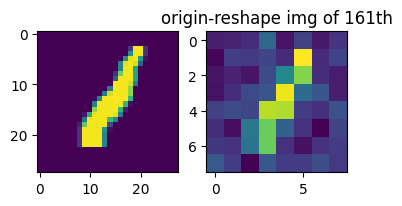

In [268]:
# Importing the required library
import matplotlib.pyplot as plt

# Creating a figure with two subplots
fig, axs = plt.subplots(1,2, figsize=(4, 8))
t = np.random.randint(0, train_size)
axs[0].imshow(x_train_origin[t])
axs[1].imshow(x_train[t])
plt.title(f'origin-reshape img of {t}th')
plt.show()

In [269]:
noise_qubits = 6
code_qubits = 1
n_qubits = noise_qubits + code_qubits
output_qubits = 6
assert(output_qubits <= noise_qubits) # 출력 큐빗은 noise qubit이하여야 한다.

n_layers = 20
BATCH_SIZE = 16
print("n_qubits = {} n_layers = {}".format(n_qubits, n_layers))

dev = qml.device("default.qubit", wires=n_qubits)

random_indices = np.random.choice(2**n_qubits, 2**output_qubits, replace=False)
mask = np.zeros(2**n_qubits, dtype=bool)
mask[random_indices] = True # amplitude embedding에 사용할 위치는 랜덤하게 고른다.

n_qubits = 7 n_layers = 20


In [270]:
coeff = 0.2

def generator_init(generator_input):
    for i in range(n_qubits):
        qml.RY(generator_input[i]*np.pi/2, wires=i) # TODO: *a 해서 값 범위 맞추기

def generator_layer(params):
    for i in range(n_qubits):
        qml.RX(params[i][0], wires=i)
        qml.RY(params[i][1], wires=i)
        qml.RZ(params[i][2], wires=i)
    
    for i in range(n_qubits):
        qml.CNOT(wires=[i, (i+1)%n_qubits])

@qml.qnode(dev, interface="torch")
def generator_circuit(params, generator_input):
    """
    quantum circuit nodeq1
    generator_input (np.array(큐빗)) : 생성기 입력 seed (noise + code)
    params (torch.Tensor(레이어,큐빗,3)): a parameter
    마지막 측정은 모두 Z로
    """

    generator_init(generator_input)

    for param in params:
        generator_layer(param)

    return qml.probs(wires=range(n_qubits))

def generator_forward(params, generator_input):
    # 제너레이터 돌리고 결과 return하는 함수
    generator_output = [generator_circuit(params, single_in) for single_in in generator_input] # (BATCH_SIZE, 2**n_qubits) 차원
    generator_output = torch.stack(generator_output) # (BATCH_SIZE, 2**n_qubits) 차원
    generator_output = 2 / np.pi * torch.arcsin(torch.sqrt(generator_output)) # (BATCH_SIZE, n_qubits) 차원
    # 곱하기 2 해서 범위를 초과하게 만들음
    output = generator_output[:, mask]
    output[output <= output.mean() * 0.7] = 0
    output = output / output.max(dim=1, keepdim=True)[0]

    return output, generator_output[:, -code_qubits:] # noise, code 순서로 반환


def generator_train_step(params, generator_input, use_mine = False, _qmine = False):
    '''
    params (torch.Tensor(레이어,큐빗,3)): a parameter
    generator_input (torch.Tensor(BATCH_SIZE, n_qubits)): 생성기 입력 seed (noise + code). -1~1 사이의 값
    '''
    code_input = generator_input[:, -code_qubits:] # 입력중에서 code만 뽑는다. (BATCH_SIZE, code_qubits)

    generator_output, code_output = generator_forward(params, generator_input) # 출력을 뽑아낸다
    generator_output = generator_output.to(torch.float32) # (BATCH_SIZE, output_qubits)
    
    disc_output = discriminator(generator_output) # 밑에 코드에서 정의됨
    gan_loss = torch.log(1-disc_output).mean()
    # print("gan_loss = ", gan_loss, gan_loss.shape)
    
    t = (code_input - code_output).pow(2).mean()

    if use_mine:
        pred_xy = mine(code_input, generator_output)
        code_input_shuffle = code_input[torch.randperm(BATCH_SIZE)]
        pred_x_y = mine(code_input_shuffle, generator_output)
        mi = torch.mean(pred_xy) - torch.log(torch.mean(torch.exp(pred_x_y)))
        gan_loss -= coeff * mi

    elif _qmine:
        gan_loss += 0 # TODO: qmine loss 추가하기

    return generator_output, gan_loss+t*0, gan_loss, t # TODO: 이건 분석용으로 넣어놓음.지워야 함.


def prediction(params, image, debug=False):
    prob_0 = 0
    prob_1 = 0
    for i in range(n_layers):
        prob_0 += circuit(params[:i+1], (image, 0))
        prob_1 += circuit(params[:i+1], (image, 1))

    if (debug):
        return (int(prob_0 <= prob_1), prob_0, prob_1)
    return int(prob_0 <= prob_1)

In [271]:
import torch.nn as nn
from torch.nn import functional as F

class LinearDiscriminator(nn.Module):
    def __init__(self, input_dim=2**output_qubits):
        super().__init__()
        self.hidden_size = 50
        self.layers = nn.Sequential(
            nn.Linear(input_dim, self.hidden_size),
            nn.LeakyReLU(),
            nn.Linear(self.hidden_size, self.hidden_size),
            nn.LeakyReLU(),
            nn.Linear(self.hidden_size, self.hidden_size),
            nn.LeakyReLU(),
            nn.Linear(self.hidden_size, 1),
            nn.Sigmoid())

        self.input_dim = input_dim

    def forward(self, x):
        if(len(x.shape) != 2):
            x = x.view(x.shape[0], -1)

        return self.layers(x)


class LinearMine(nn.Module):
    def __init__(self):
        super(LinearMine, self).__init__()
        H = 20
        self.fc1 = nn.Linear(code_qubits, H)
        self.fc2 = nn.Linear(2**output_qubits, H)
        self.fc3 = nn.Linear(H, 1)

    def forward(self, x, y):
        h1 = F.relu(self.fc1(x)+self.fc2(y))
        h2 = self.fc3(h1)
        return h2

disc_loss_fn = nn.BCELoss()
def disc_cost_fn(real_input, fake_input, smoothing=False):
    batch_num = real_input.shape[0]

    disc_real = discriminator(real_input)
    disc_fake = discriminator(fake_input)

    real_label = torch.ones((batch_num, 1)).to(device)
    fake_label = torch.zeros((batch_num, 1)).to(device)
    
    if smoothing:
        real_label = real_label - 0.2*torch.rand(real_label.shape).to(device)
    
    loss = 0.5 * (disc_loss_fn(disc_real, real_label) + disc_loss_fn(disc_fake, fake_label))
    
    return loss


In [272]:
generator_params = Variable(torch.tensor(np.random.normal(-np.pi, np.pi, (n_layers, n_qubits, 3))), requires_grad=True)
print("parameter shape: ", generator_params.shape)

discriminator = LinearDiscriminator()
mine = LinearMine()

parameter shape:  torch.Size([20, 7, 3])


In [273]:
G_lr = 1e-3
D_lr = 3e-4
M_lr = 1e-3
use_mine = True
use_qmine = False
G_opt = torch.optim.Adam([generator_params], lr=G_lr)
D_opt = torch.optim.Adam(discriminator.parameters(), lr=D_lr)
M_opt = torch.optim.Adam(mine.parameters(), lr=M_lr)

G_scheduler = torch.optim.lr_scheduler.StepLR(G_opt, step_size=30, gamma=0.7)
D_scheduler = torch.optim.lr_scheduler.StepLR(D_opt, step_size=30, gamma=0.85)
M_scheduler = torch.optim.lr_scheduler.StepLR(M_opt, step_size=30, gamma=0.7)

In [275]:
import os
title = 'try2'
folder_paths = [f'result/{title}', f'result/{title}/savepoints', f'result/{title}/graphs', f'result/{title}/samples']
for path in folder_paths:
    if not os.path.exists(path):
        os.makedirs(path)
    
with open(f'result/{title}/param.txt', 'w') as f:
    f.write('G_lr = {}\n'.format(G_lr))
    f.write('D_lr = {}\n'.format(D_lr))
    f.write('M_lr = {}\n'.format(M_lr))
    f.write('G_scheduler: step={}, gamma={}\n'.format(G_scheduler.step_size, G_scheduler.gamma))
    f.write('D_scheduler: step={}, gamma={}\n'.format(D_scheduler.step_size, D_scheduler.gamma))
    f.write('M_scheduler: step={}, gamma={}\n'.format(M_scheduler.step_size, M_scheduler.gamma))
    f.write('coeff = {}\n'.format(coeff))
    f.write('use_mine = {}\n'.format(use_mine))
    f.write('use_qmine = {}\n'.format(use_qmine))
    f.write('n_qubits = {}\n'.format(n_qubits))
    f.write('output_qubits = {}\n'.format(output_qubits))
    f.write('code_qubits = {}\n'.format(code_qubits))
    f.write('n_layers = {}\n'.format(n_layers))
    f.write('param shape = {}\n'.format(generator_params.shape))

In [276]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

def visualize_output(log_gen_outputs, log_gen_codes, title, rep, recorder):

    # 이미지 리스트에서 랜덤하게 8개 이미지 선택
    num_images = 8
    image_list = log_gen_outputs
    image_indices = np.random.choice(len(image_list), num_images, replace=False)
    selected_images = [image_list[i] for i in image_indices]

    # 선택된 이미지를 8x8 크기로 reshape
    reshaped_images = [image.reshape(8, 8) for image in selected_images]

    # 이미지를 2x4 배치로 그리기 위한 그리드 설정
    grid_rows = 2
    grid_cols = 4
    gs = GridSpec(grid_rows, grid_cols)

    # 이미지를 그리드에 배치하고 시각화
    plt.figure(figsize=(10, 6))
    for i, image in enumerate(reshaped_images):
        row = i // grid_cols
        col = i % grid_cols
        ax = plt.subplot(gs[row, col])
        ax.imshow(image, cmap='gray')  # 이미지를 회색조로 표시
        ax.axis('off')

    plt.tight_layout()
    plt.suptitle(f"Epoch {rep}, random imgs", fontsize=16)
    plt.savefig(f'result/{title}/samples/{rep}.png')
    plt.show()

    
    plt.figure()
    plt.plot(recorder['g_loss'], label='g_loss', marker='o')
    plt.plot(recorder['d_loss'], label='d_loss', marker='o')
    plt.plot(recorder['mi'], label='mi', marker='o')
    plt.legend()
    plt.title(f'Epoch {rep}, loss graph')
    plt.savefig(f'result/{title}/graphs/{rep}.png')
    plt.show()
    

100%|██████████| 31/31 [01:14<00:00,  2.39s/it, G_loss=-.666, D_loss=0.683, MI=5.33e-6] 


epoch: 1, D_loss: 0.6828616126891105, G_loss: -0.6662515997886658, MI = 5.325963420252646e-06
a_loss: -41.30759918689728, b_loss: 20.576997164315728


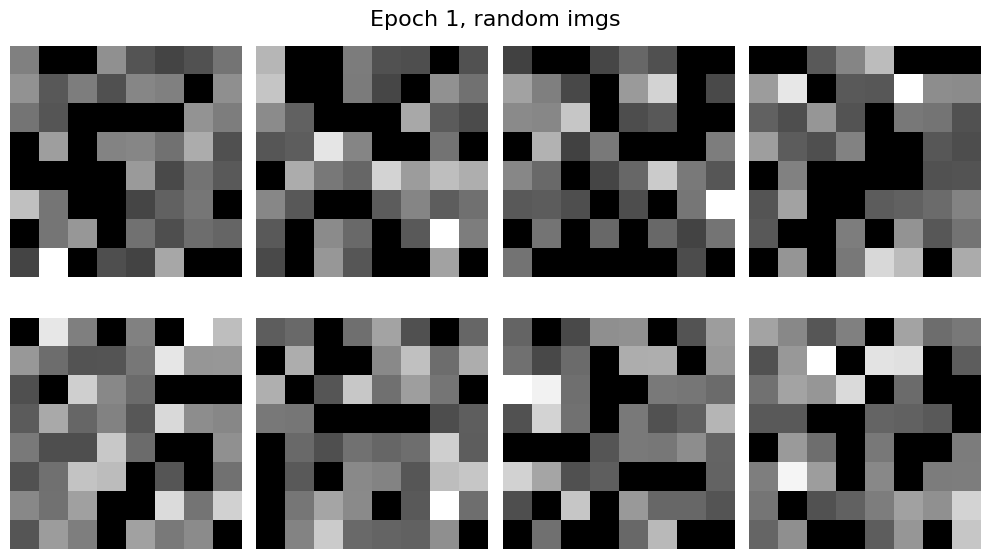

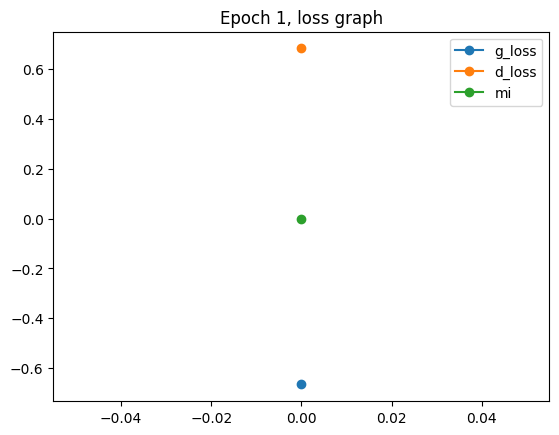

100%|██████████| 31/31 [01:15<00:00,  2.43s/it, G_loss=-.619, D_loss=0.631, MI=0.0115] 


epoch: 2, D_loss: 0.6305105320868953, G_loss: -0.6187571517882808, MI = 0.011455664711613809
a_loss: -38.36294341087341, b_loss: 20.87042147714745


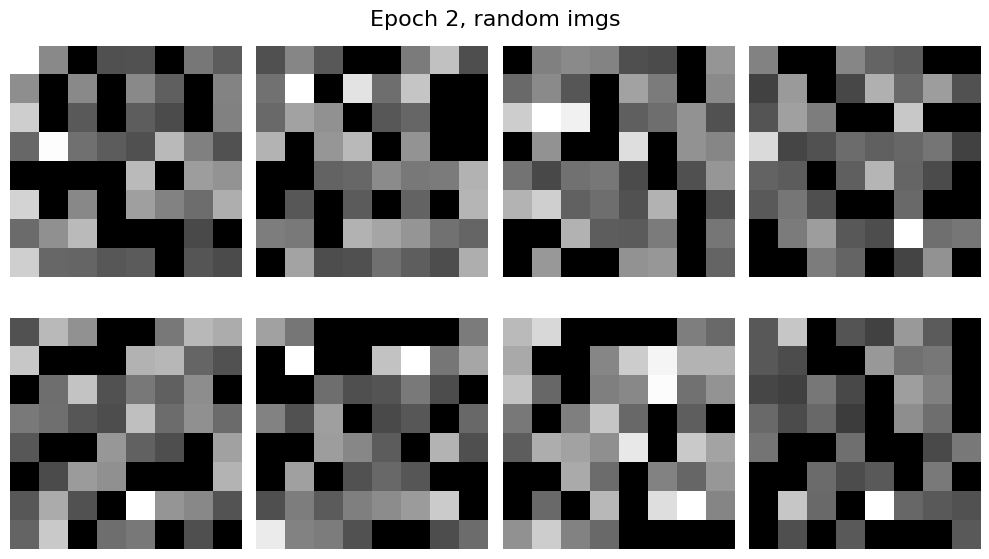

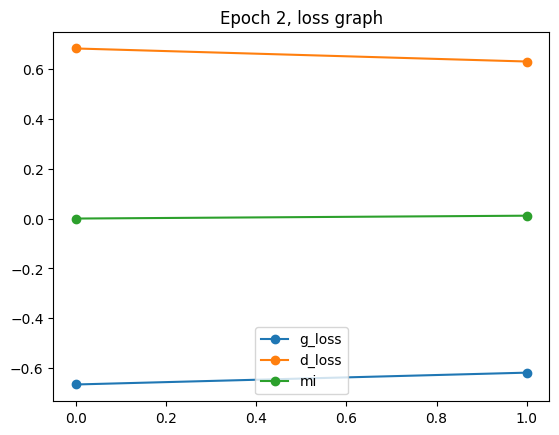

100%|██████████| 31/31 [01:09<00:00,  2.26s/it, G_loss=-.463, D_loss=0.484, MI=0.0256]

epoch: 3, D_loss: 0.48379104944967455, G_loss: -0.46268090798008826, MI = 0.025582626942665346
a_loss: -28.686216294765472, b_loss: 20.011018481909804


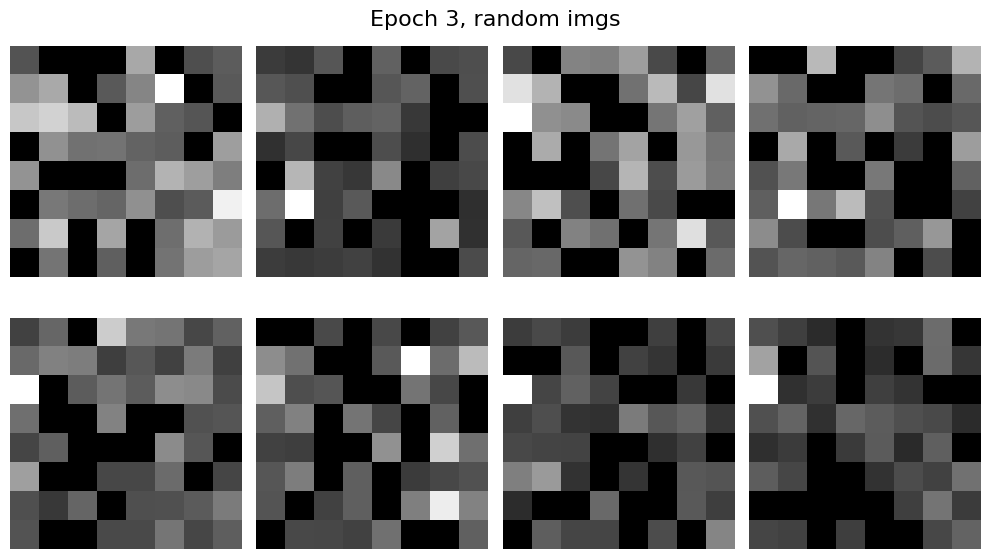

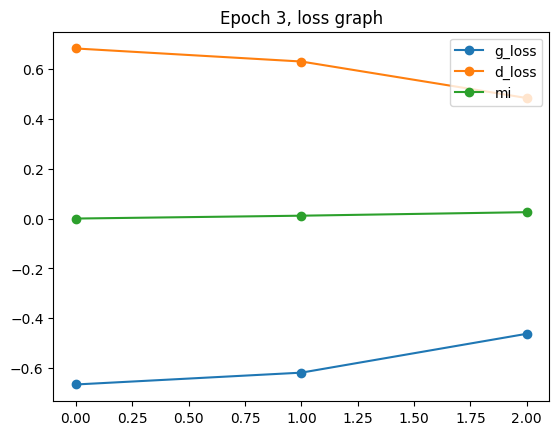

100%|██████████| 31/31 [01:13<00:00,  2.37s/it, G_loss=-.216, D_loss=0.229, MI=0.0322]

epoch: 4, D_loss: 0.22911144432521635, G_loss: -0.21576569734081144, MI = 0.032211495983985164
a_loss: -13.37747323513031, b_loss: 19.792482412222263


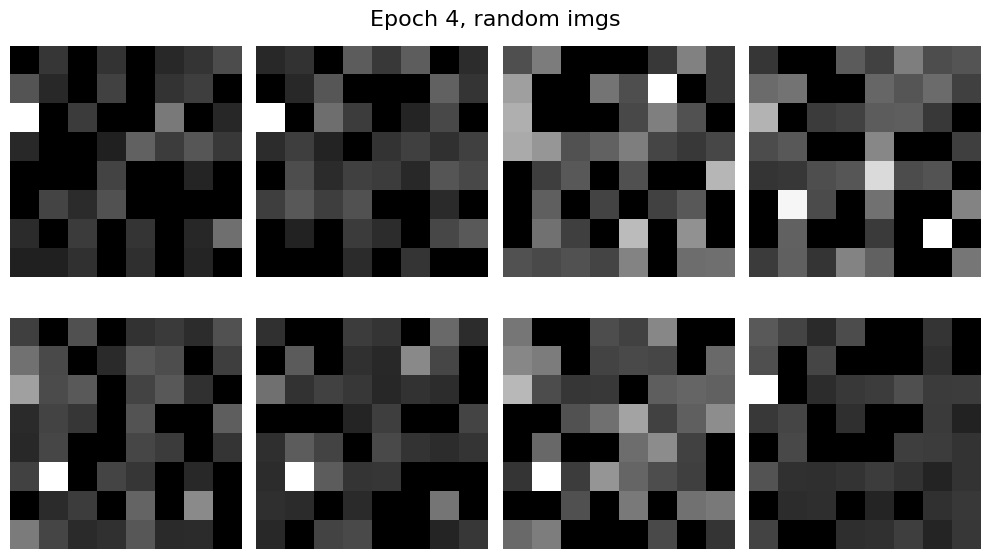

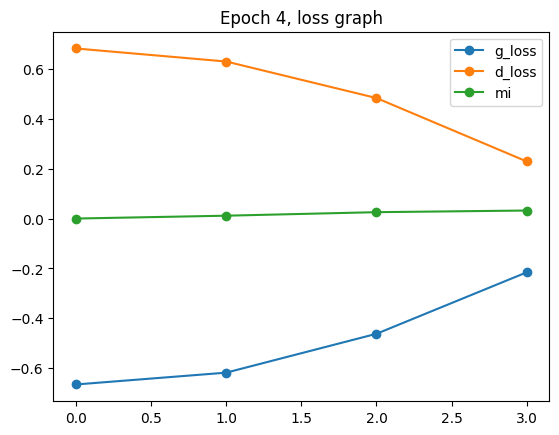

100%|██████████| 31/31 [01:08<00:00,  2.20s/it, G_loss=-.0889, D_loss=0.0747, MI=0.0417]

epoch: 5, D_loss: 0.07470993577472625, G_loss: -0.08891575987781247, MI = 0.0417073292116965
a_loss: -5.512777112424374, b_loss: 20.644225559552968


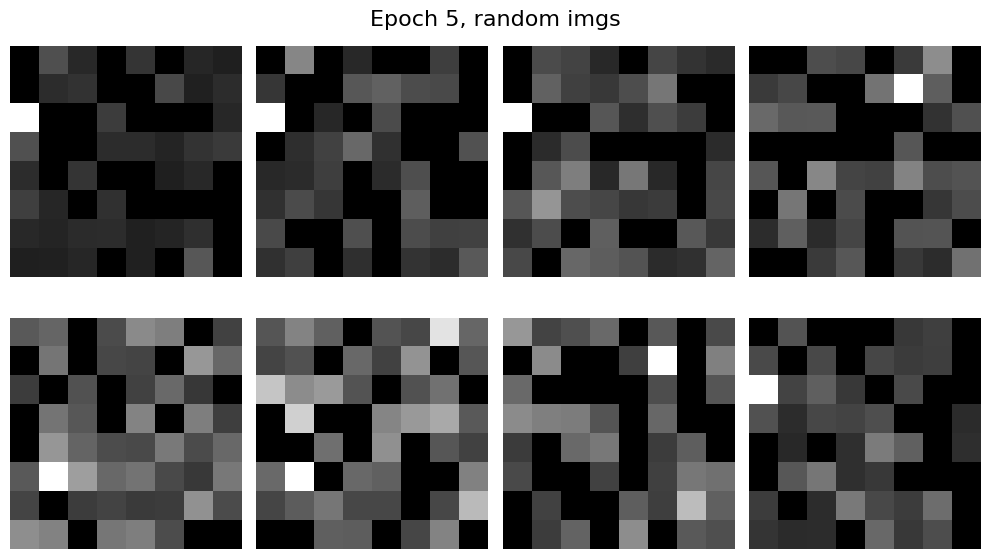

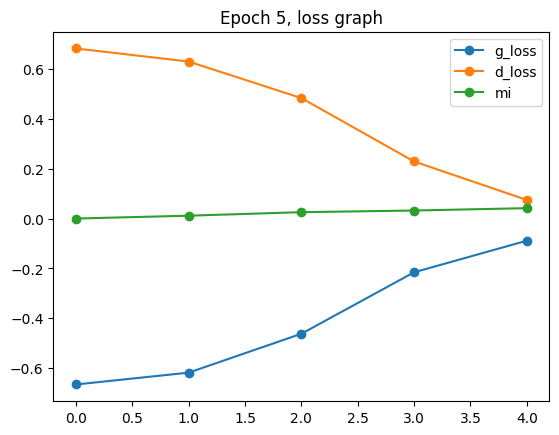

100%|██████████| 31/31 [01:13<00:00,  2.38s/it, G_loss=-.05, D_loss=0.0324, MI=0.0537]  

epoch: 6, D_loss: 0.03235286035605015, G_loss: -0.049965807266773715, MI = 0.05368225997494113
a_loss: -3.0978800505399704, b_loss: 21.155209374762563


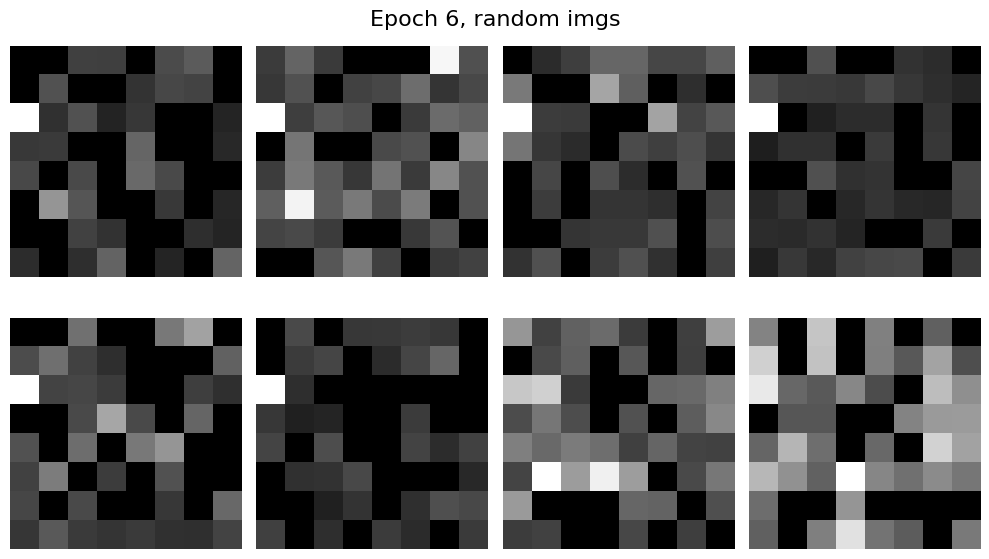

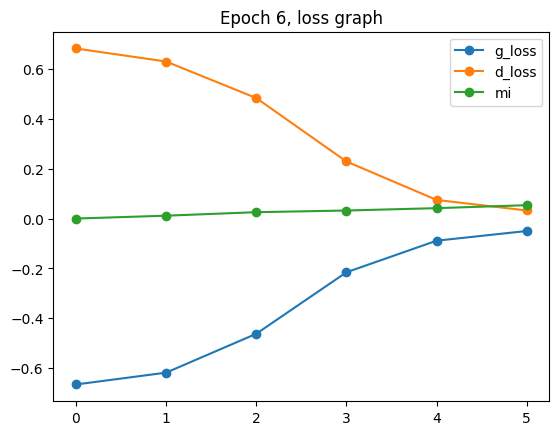

100%|██████████| 31/31 [01:07<00:00,  2.18s/it, G_loss=-.0376, D_loss=0.0173, MI=0.0897]

epoch: 7, D_loss: 0.017332910920583432, G_loss: -0.03758685879649654, MI = 0.0897042078356589
a_loss: -2.330385245382786, b_loss: 22.85713492874332


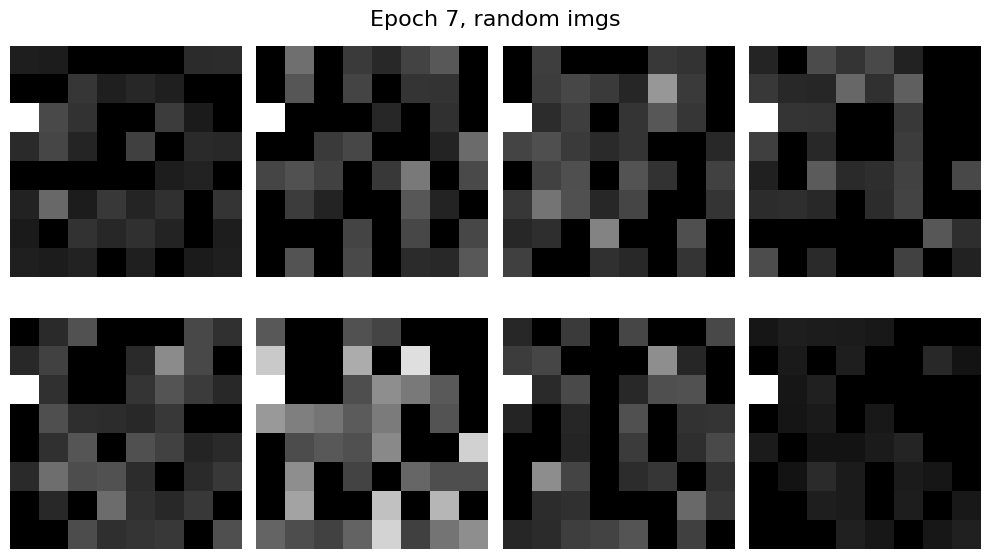

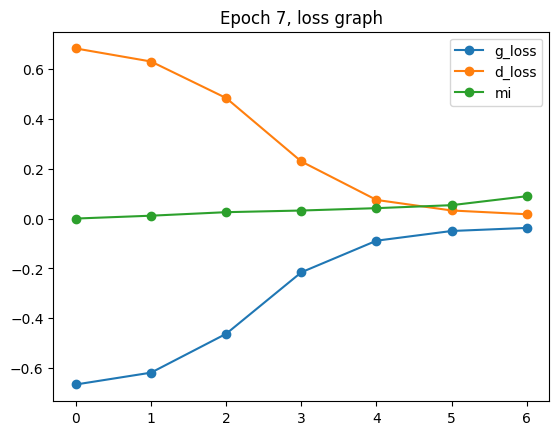

100%|██████████| 31/31 [01:04<00:00,  2.09s/it, G_loss=-.0344, D_loss=0.0121, MI=0.0893]


epoch: 8, D_loss: 0.012077310137570865, G_loss: -0.034368450212622845, MI = 0.08927940745507518
a_loss: -2.1308439131826162, b_loss: 17.64267806708268


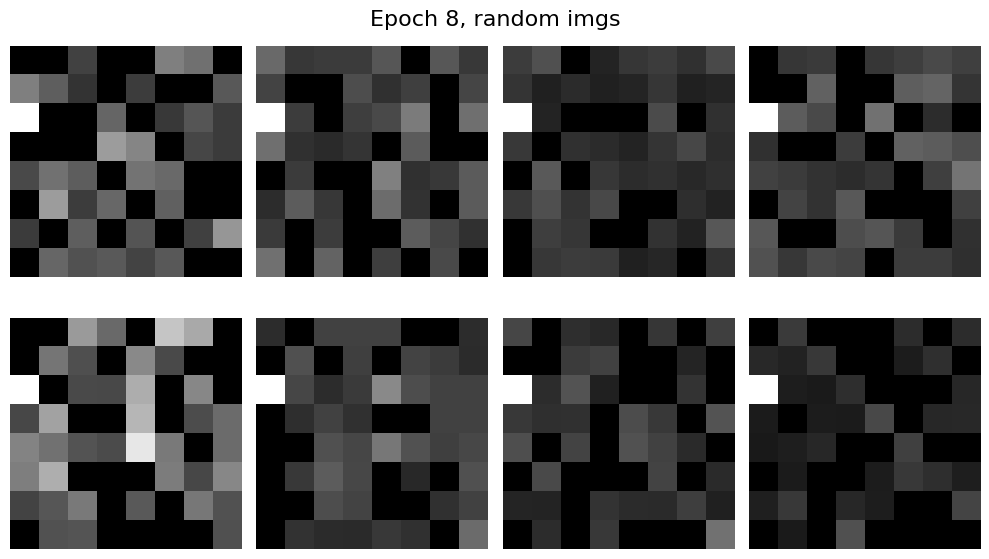

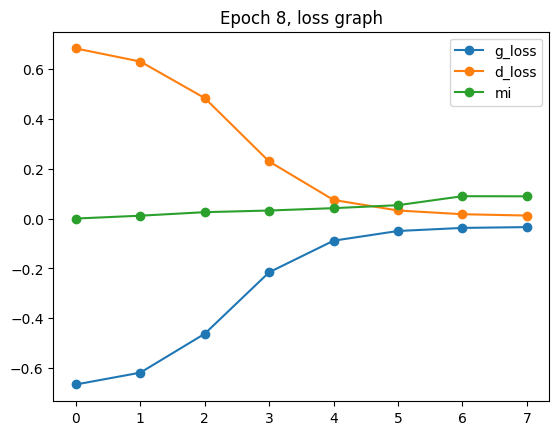

100%|██████████| 31/31 [01:04<00:00,  2.09s/it, G_loss=-.0382, D_loss=0.00871, MI=0.122]

epoch: 9, D_loss: 0.00871198053561872, G_loss: -0.038248029327200304, MI = 0.12182444334030151
a_loss: -2.371377818286419, b_loss: 19.193703386150187


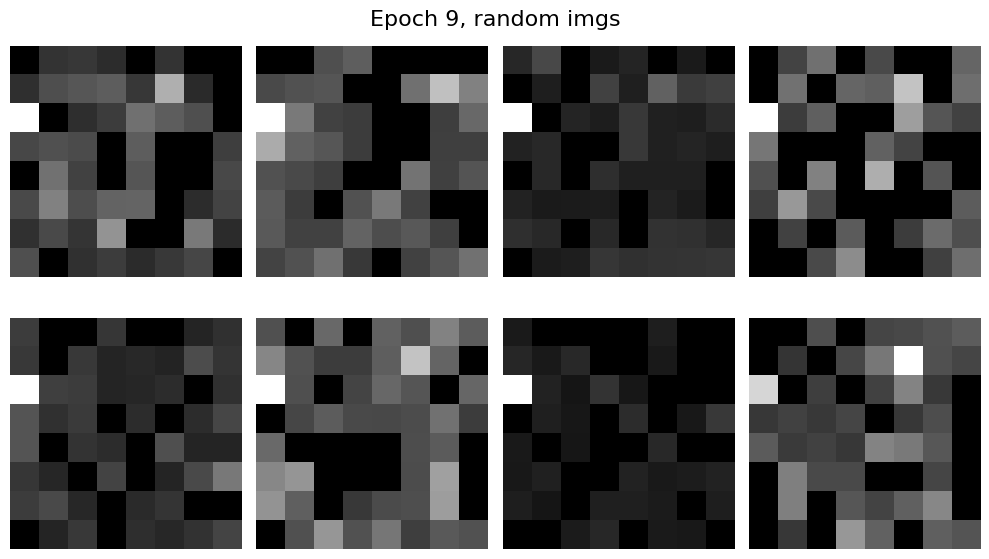

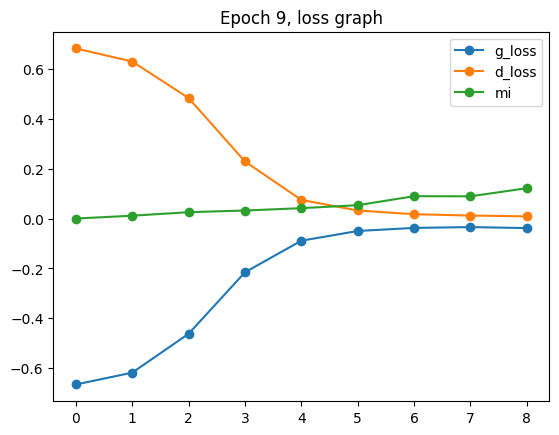

100%|██████████| 31/31 [01:10<00:00,  2.29s/it, G_loss=-.0487, D_loss=0.00541, MI=0.197]

epoch: 10, D_loss: 0.005413710612863783, G_loss: -0.04865134477375015, MI = 0.19686793896459764
a_loss: -3.0163833759725094, b_loss: 19.91975871560283


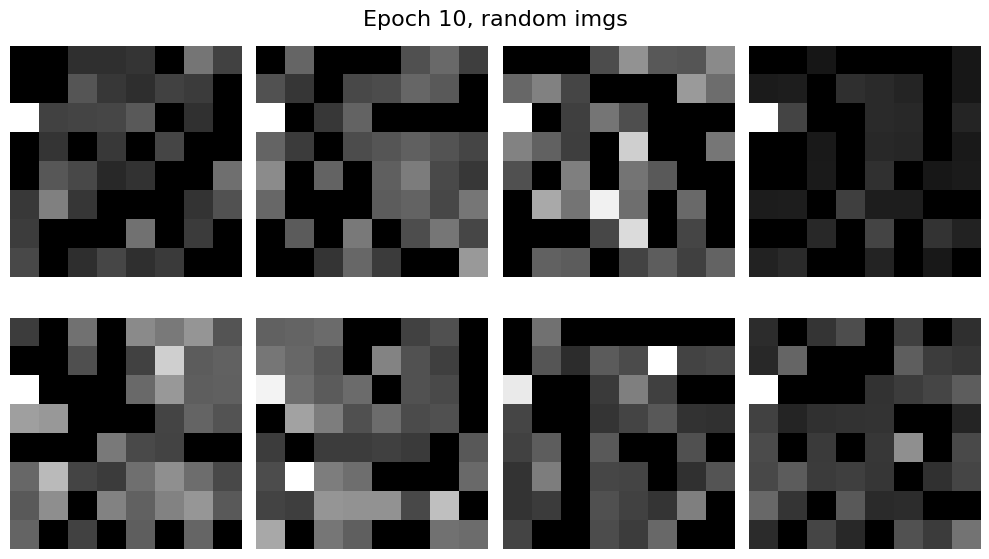

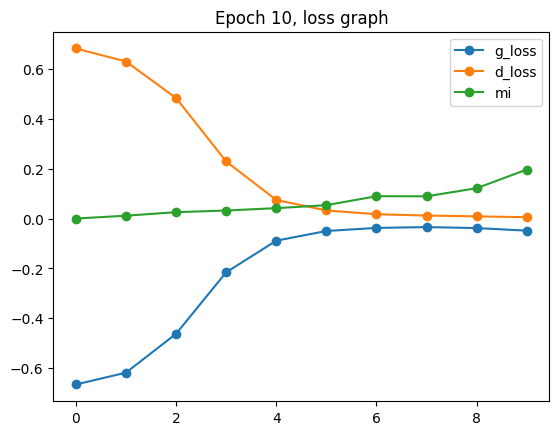

100%|██████████| 31/31 [01:13<00:00,  2.37s/it, G_loss=-.0602, D_loss=0.00398, MI=0.307]

epoch: 11, D_loss: 0.003980519963548549, G_loss: -0.060182405335287896, MI = 0.3068848819501938
a_loss: -3.7313091307878494, b_loss: 19.155086799511636


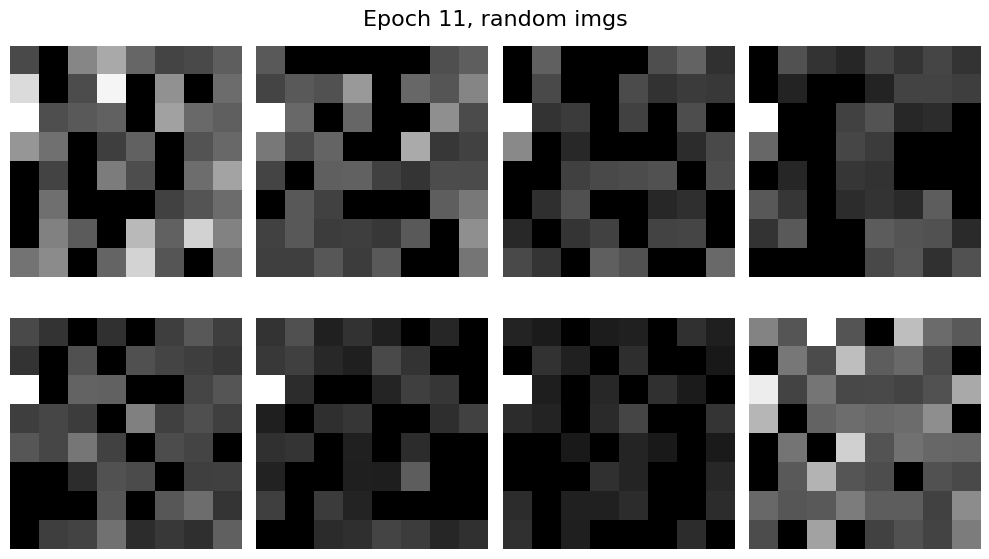

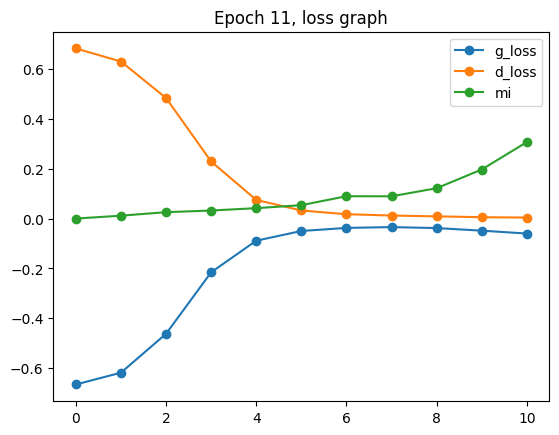

100%|██████████| 31/31 [01:06<00:00,  2.16s/it, G_loss=-.084, D_loss=0.0024, MI=0.339]  

epoch: 12, D_loss: 0.0023995949680195943, G_loss: -0.08399664015779572, MI = 0.3392762397566149
a_loss: -5.207791689783335, b_loss: 19.89507924260848


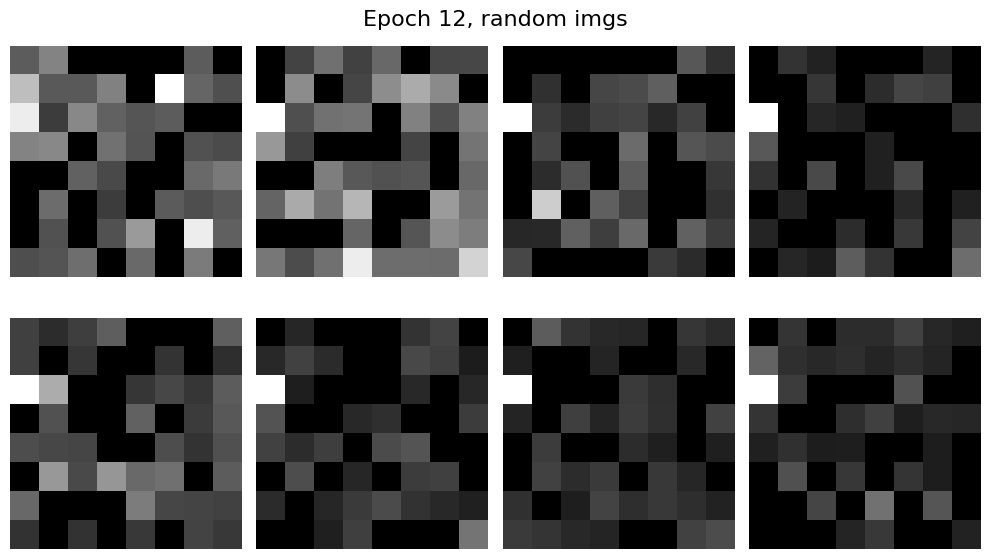

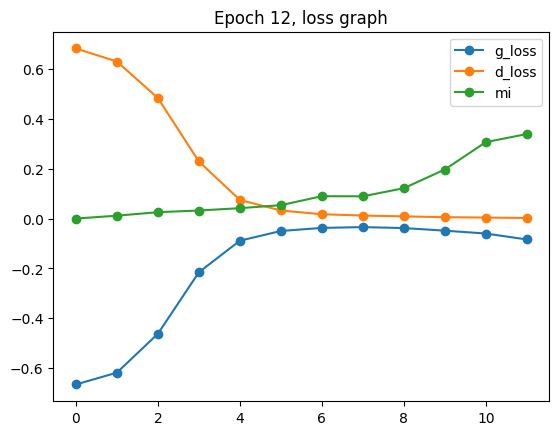

100%|██████████| 31/31 [01:05<00:00,  2.12s/it, G_loss=-.101, D_loss=0.00163, MI=0.446] 


epoch: 13, D_loss: 0.0016275671509755475, G_loss: -0.10082531407956154, MI = 0.44623030097253863
a_loss: -6.2511694729328156, b_loss: 20.426738256850236


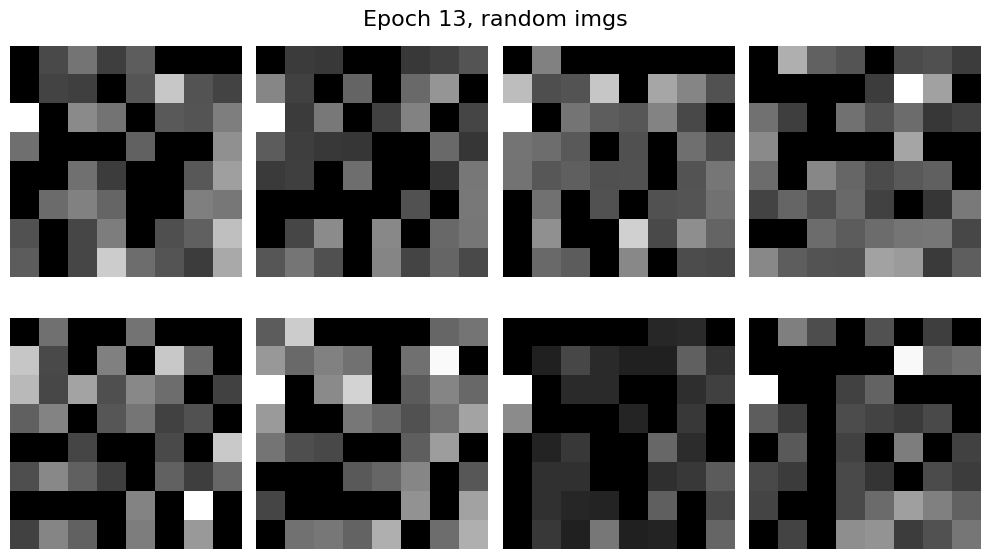

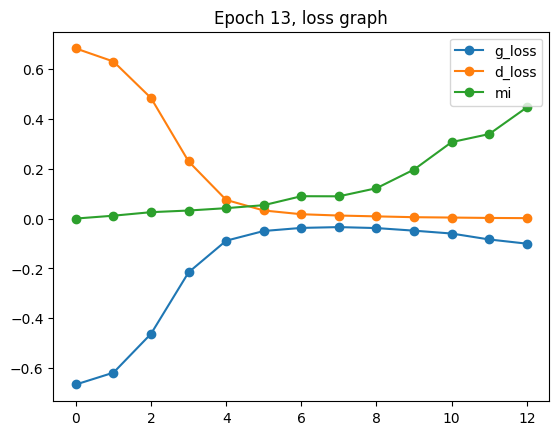

100%|██████████| 31/31 [01:05<00:00,  2.10s/it, G_loss=-.112, D_loss=0.00139, MI=0.538]

epoch: 14, D_loss: 0.0013889355937980355, G_loss: -0.11212535034264287, MI = 0.5381576457331257
a_loss: -6.951771721243858, b_loss: 19.747881133882984


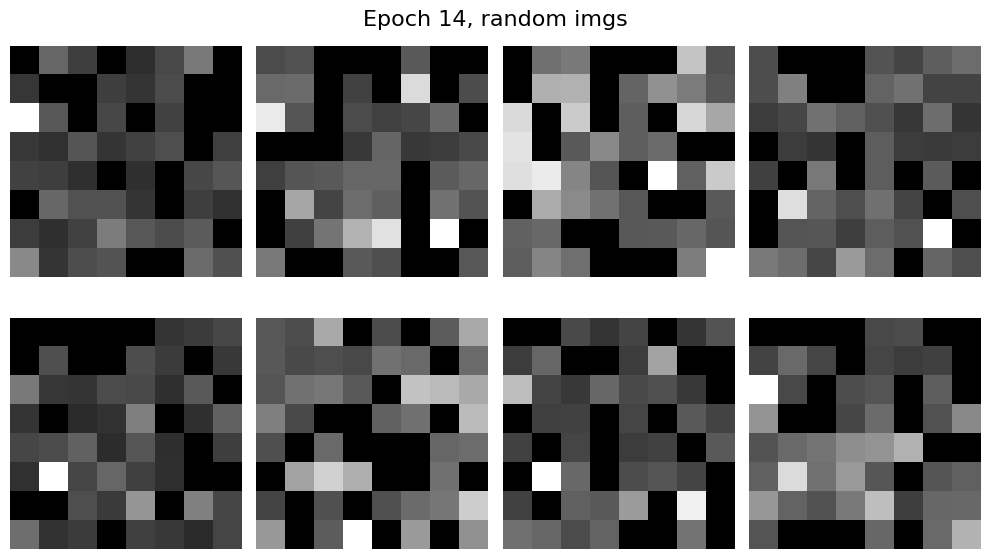

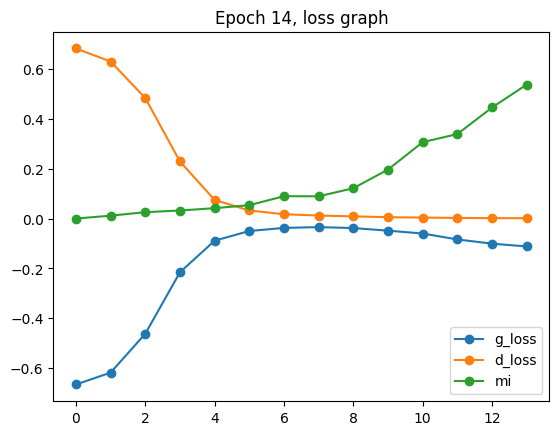

100%|██████████| 31/31 [01:05<00:00,  2.11s/it, G_loss=-.126, D_loss=0.00086, MI=0.634] 

epoch: 15, D_loss: 0.0008604078686931321, G_loss: -0.1262351411484903, MI = 0.6341514049037811
a_loss: -7.826578751206398, b_loss: 19.405221093433667


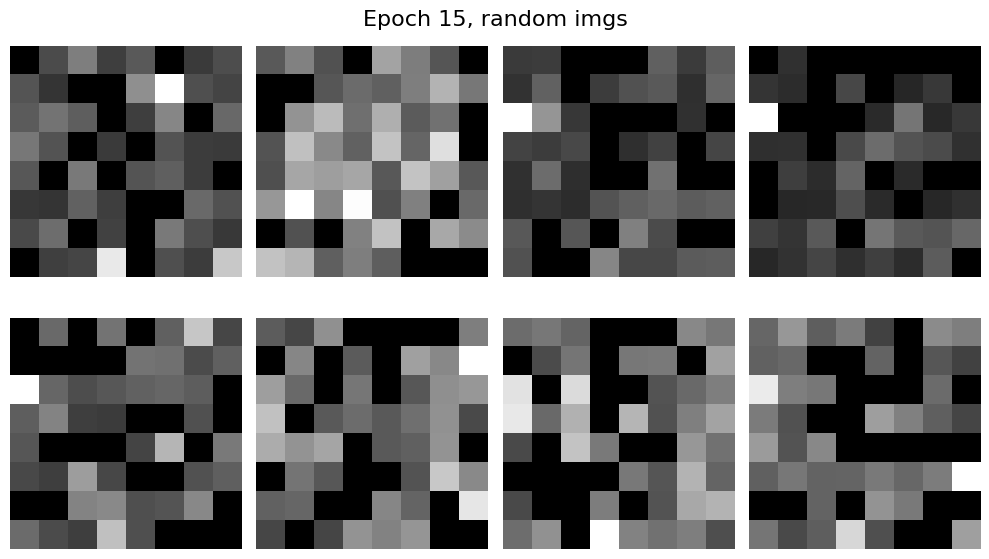

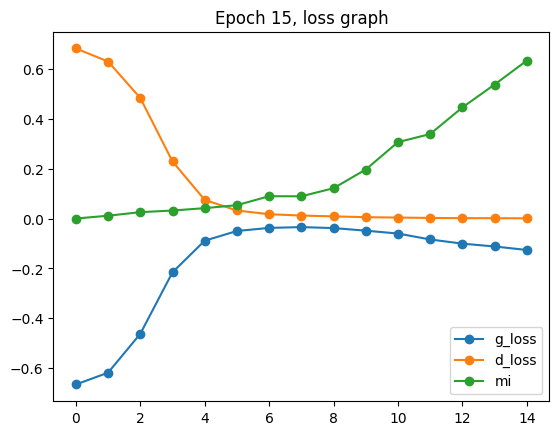

100%|██████████| 31/31 [01:06<00:00,  2.14s/it, G_loss=-.129, D_loss=0.000804, MI=0.622]


epoch: 16, D_loss: 0.0008040524844545871, G_loss: -0.12867233061021374, MI = 0.6223379426425503
a_loss: -7.977684497833252, b_loss: 18.71214330036247


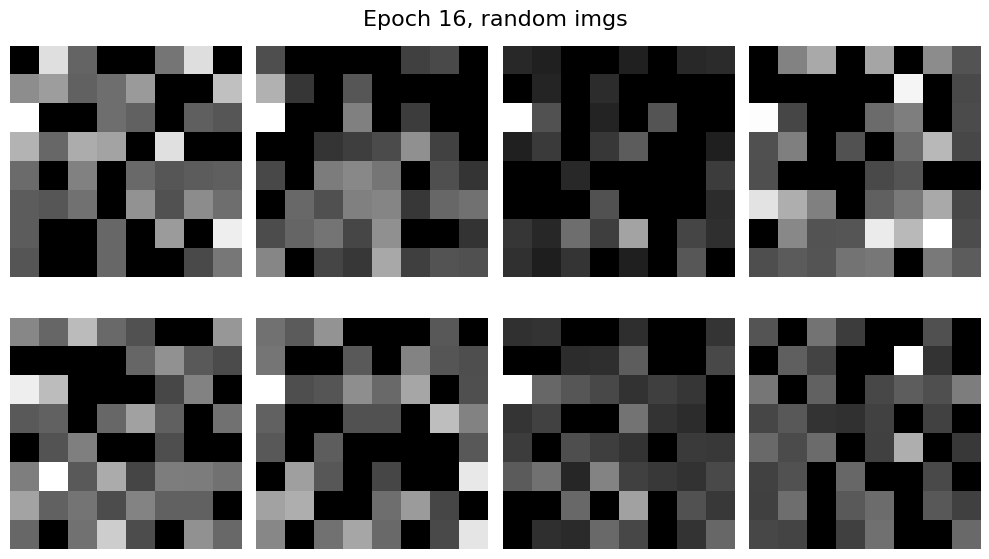

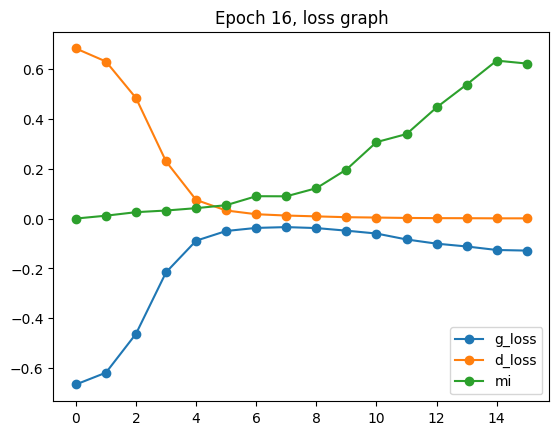

100%|██████████| 31/31 [01:13<00:00,  2.36s/it, G_loss=-.13, D_loss=0.000702, MI=0.669] 

epoch: 17, D_loss: 0.0007024846112941422, G_loss: -0.1297904379185169, MI = 0.6685437002489644
a_loss: -8.047007150948048, b_loss: 19.82196438697814


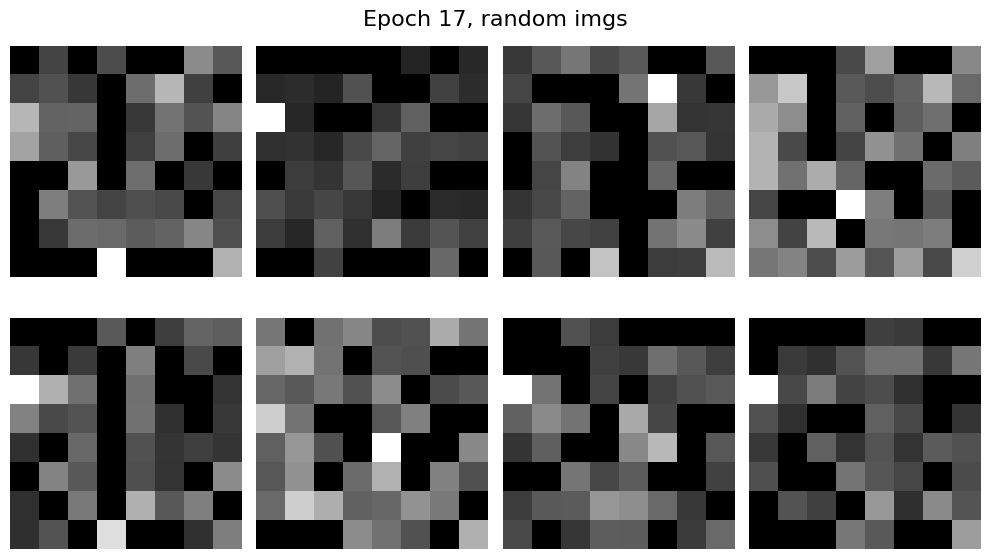

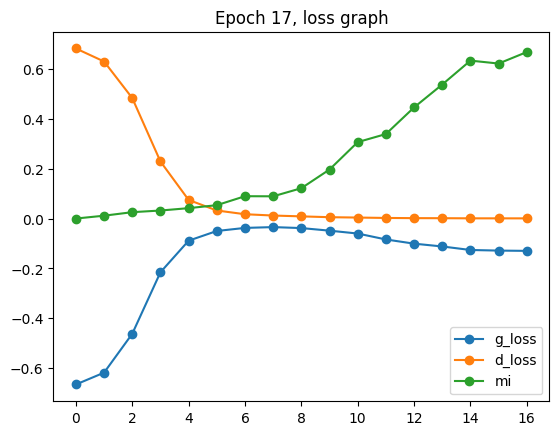

100%|██████████| 31/31 [01:14<00:00,  2.40s/it, G_loss=-.16, D_loss=0.000567, MI=0.799] 

epoch: 18, D_loss: 0.0005672465298219674, G_loss: -0.16035162813721165, MI = 0.7987912950977203
a_loss: -9.941800944507122, b_loss: 22.40658226220632


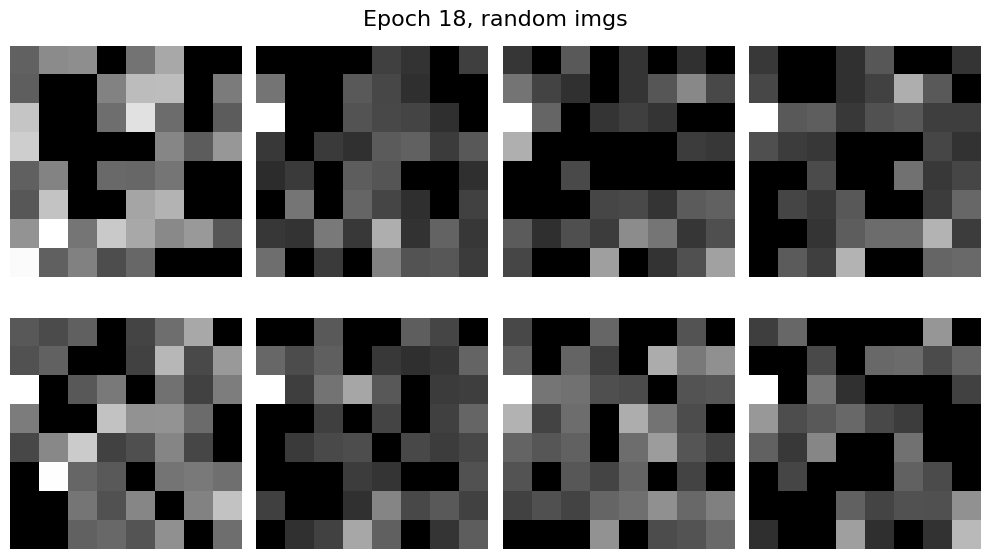

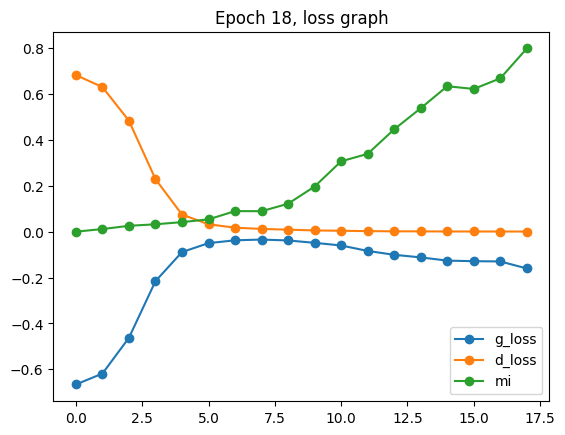

100%|██████████| 31/31 [01:13<00:00,  2.37s/it, G_loss=-.139, D_loss=0.000495, MI=0.742]

epoch: 19, D_loss: 0.0004951996776188964, G_loss: -0.13903810552531673, MI = 0.7415030156412432
a_loss: -8.620362542569637, b_loss: 18.691997201289638


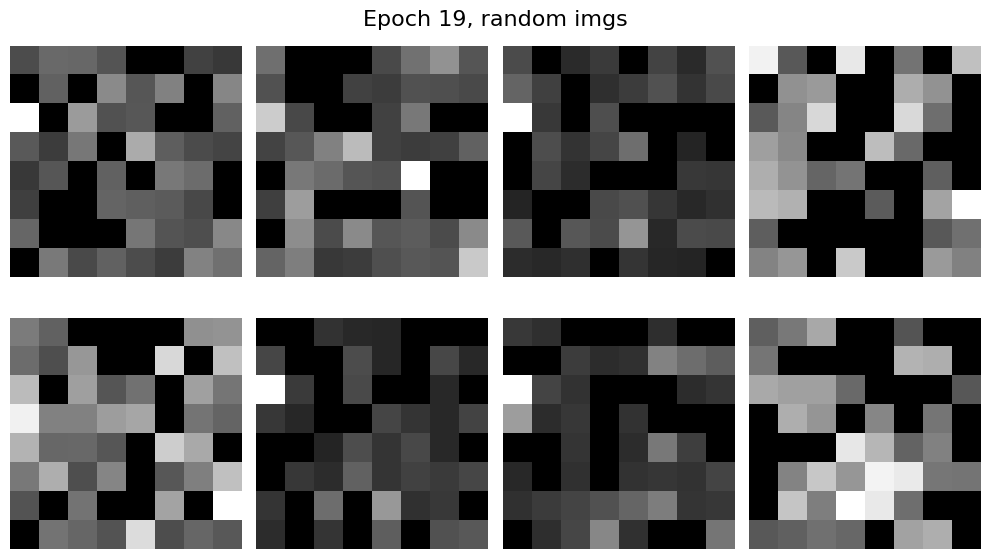

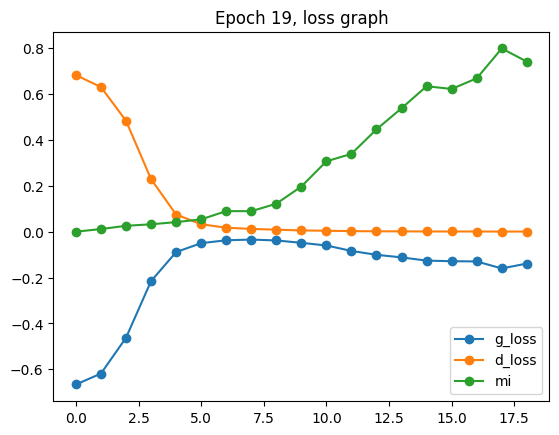

100%|██████████| 31/31 [01:08<00:00,  2.21s/it, G_loss=-.144, D_loss=0.000517, MI=0.799]


epoch: 20, D_loss: 0.0005172363021448555, G_loss: -0.14354476284596226, MI = 0.7987252550740396
a_loss: -8.899775296449661, b_loss: 21.564884014818933


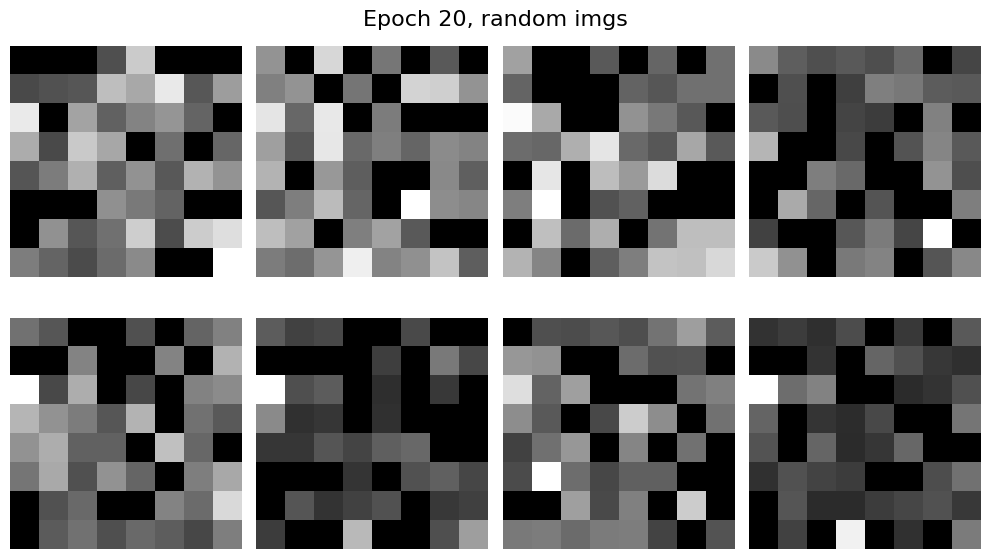

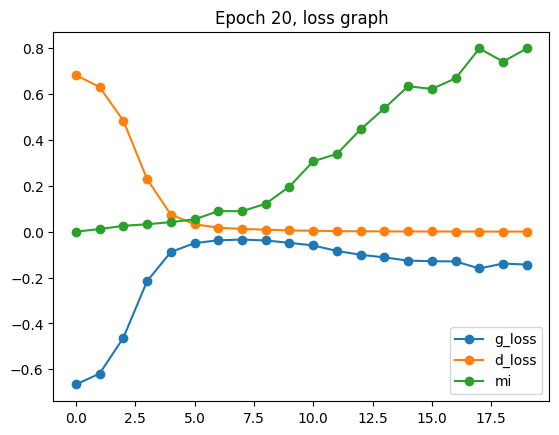

100%|██████████| 31/31 [01:11<00:00,  2.31s/it, G_loss=-.158, D_loss=0.000401, MI=0.804]

epoch: 21, D_loss: 0.00040051305991402195, G_loss: -0.157855880717116, MI = 0.8042608855232116
a_loss: -9.787064604461193, b_loss: 19.060852066867977


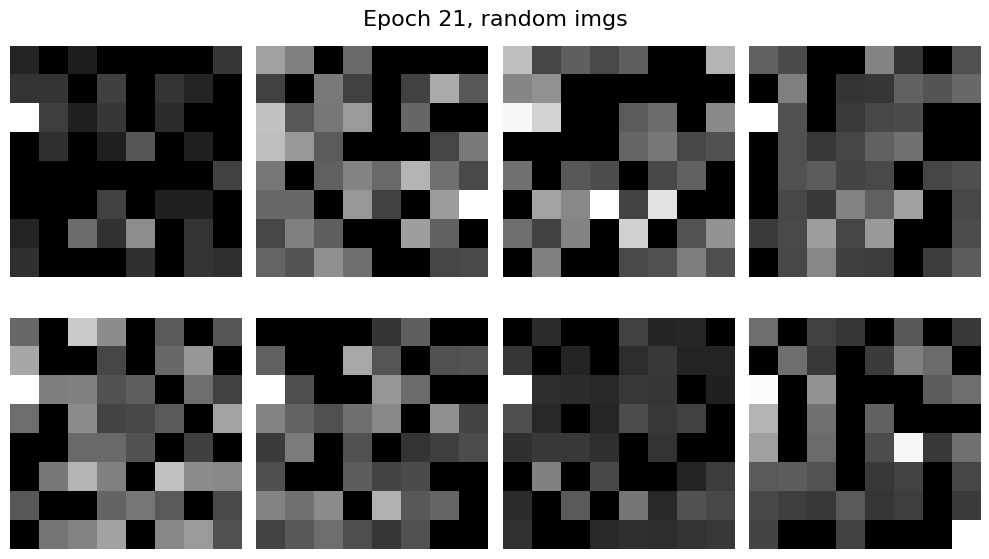

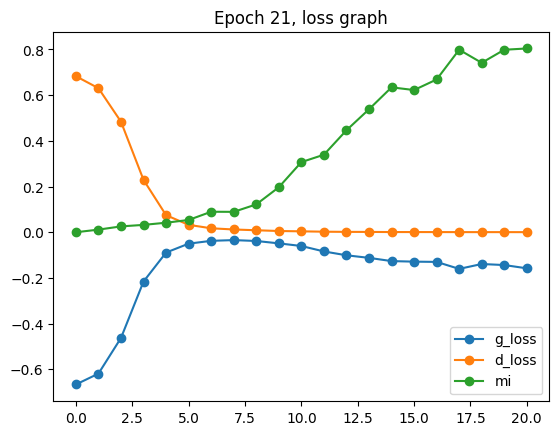

100%|██████████| 31/31 [01:08<00:00,  2.22s/it, G_loss=-.174, D_loss=0.000352, MI=0.876]

epoch: 22, D_loss: 0.0003522604355596066, G_loss: -0.17417284581930406, MI = 0.8763084190507089
a_loss: -10.798716440796852, b_loss: 19.49654358864543


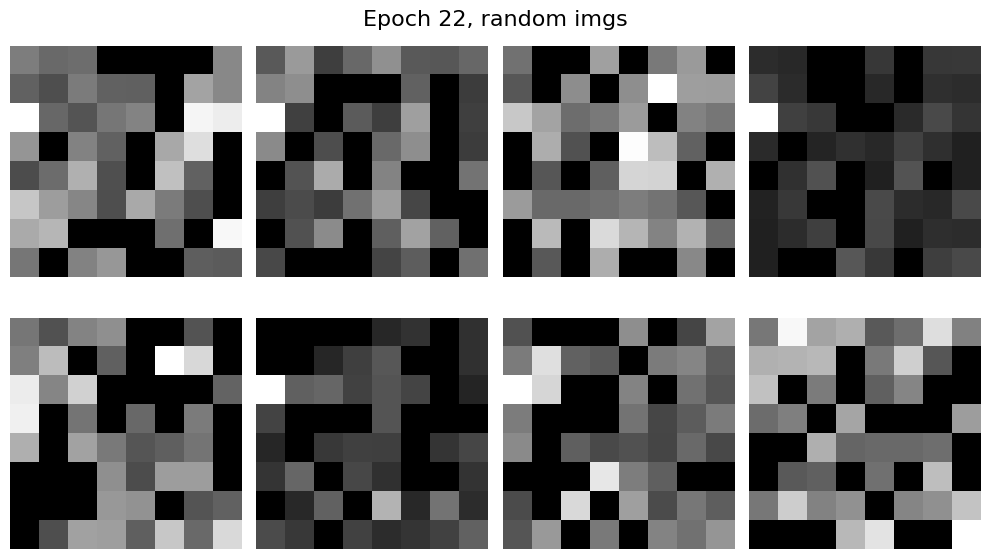

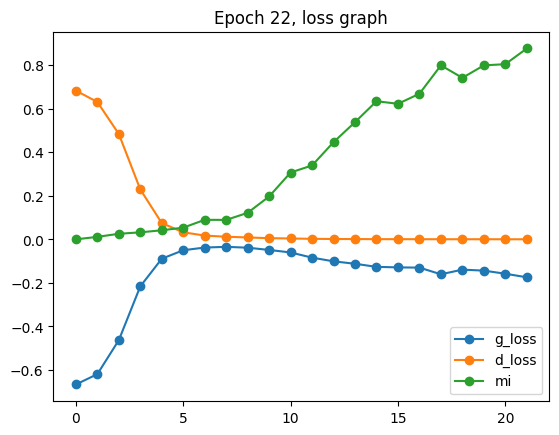

100%|██████████| 31/31 [01:12<00:00,  2.34s/it, G_loss=-.174, D_loss=0.000386, MI=0.826]

epoch: 23, D_loss: 0.0003862943485728465, G_loss: -0.1741270528685662, MI = 0.8255140425697449
a_loss: -10.795877277851105, b_loss: 18.161307346453864


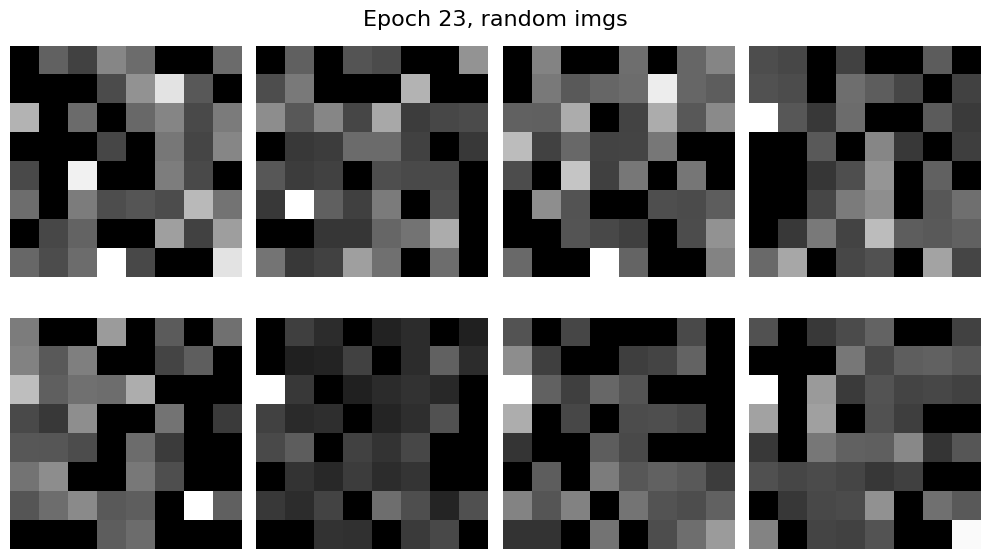

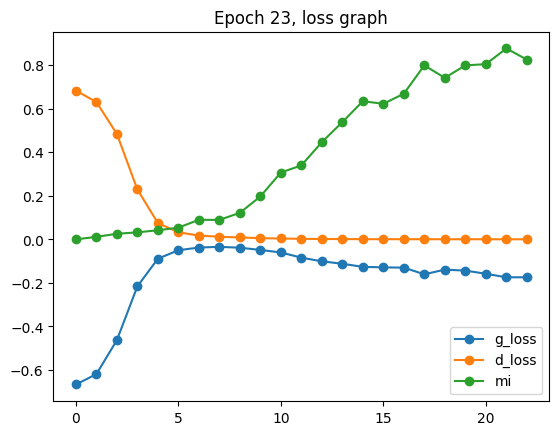

100%|██████████| 31/31 [01:11<00:00,  2.32s/it, G_loss=-.199, D_loss=0.00029, MI=1.01]  

epoch: 24, D_loss: 0.0002899568867325152, G_loss: -0.1992160024181489, MI = 1.0062730658438899
a_loss: -12.351392149925232, b_loss: 20.42577128100344


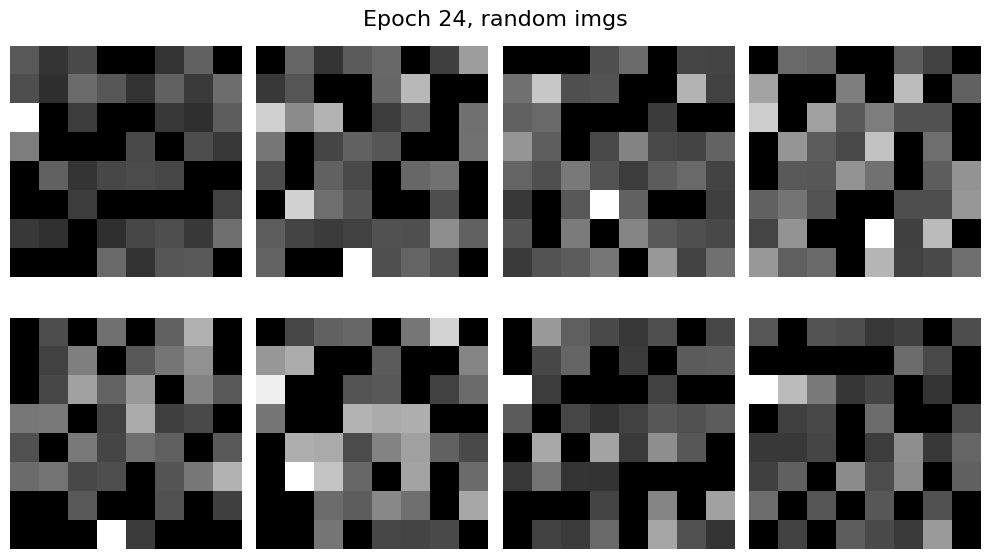

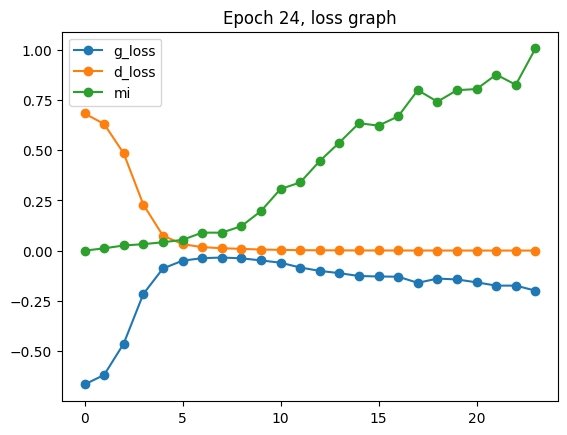

100%|██████████| 31/31 [01:12<00:00,  2.35s/it, G_loss=-.191, D_loss=0.000324, MI=0.873]

epoch: 25, D_loss: 0.00032358255961181353, G_loss: -0.1910243223030721, MI = 0.8734630778912575
a_loss: -11.84350798279047, b_loss: 20.245480784222636


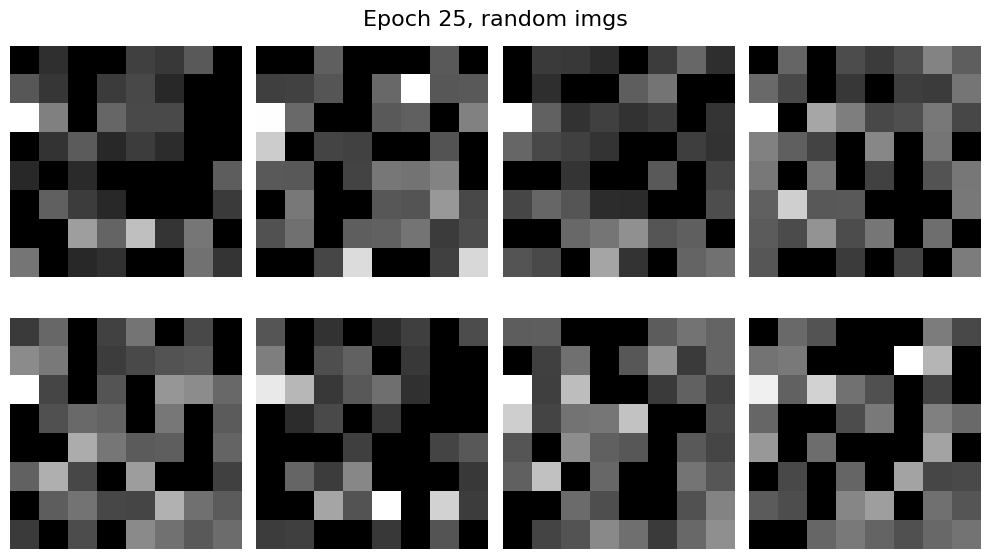

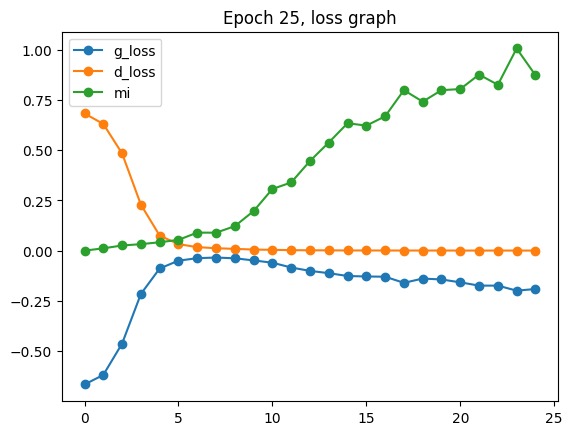

100%|██████████| 31/31 [01:12<00:00,  2.33s/it, G_loss=-.179, D_loss=0.000333, MI=0.933]

epoch: 26, D_loss: 0.00033268472790012074, G_loss: -0.17877963641958852, MI = 0.9329740510832879
a_loss: -11.084337458014488, b_loss: 18.944880892855274


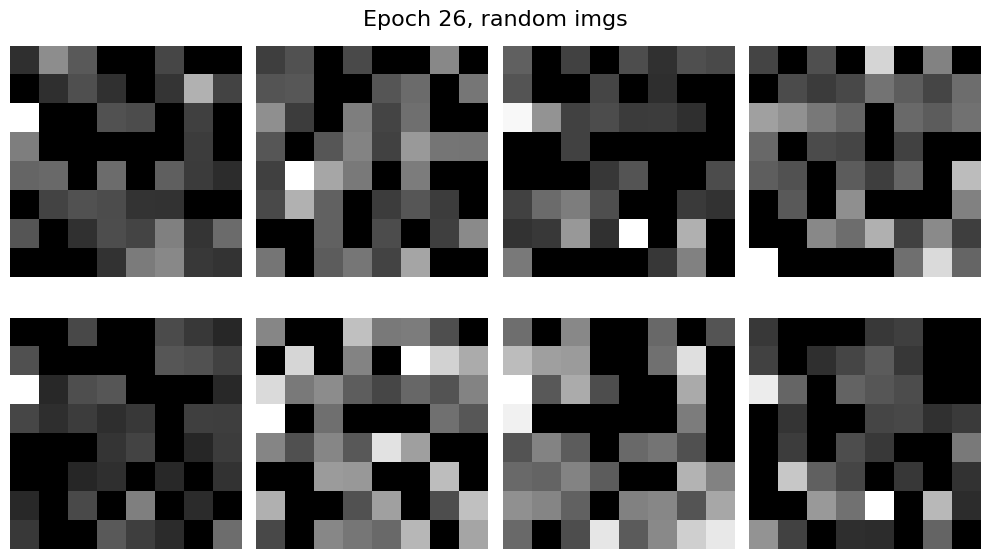

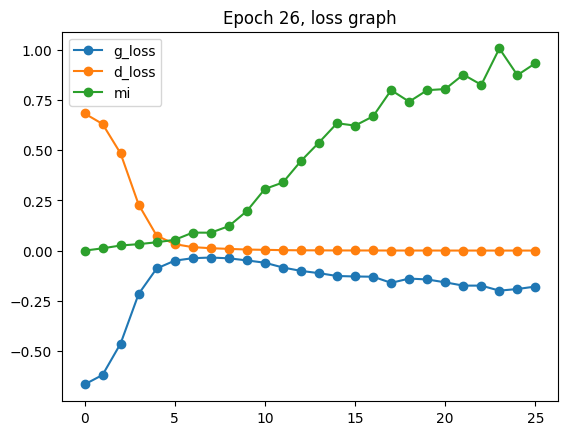

100%|██████████| 31/31 [01:11<00:00,  2.30s/it, G_loss=-.188, D_loss=0.000392, MI=0.928]


epoch: 27, D_loss: 0.0003924101946458611, G_loss: -0.1883591391867207, MI = 0.9281112234438619
a_loss: -11.678266629576683, b_loss: 19.190033055297473


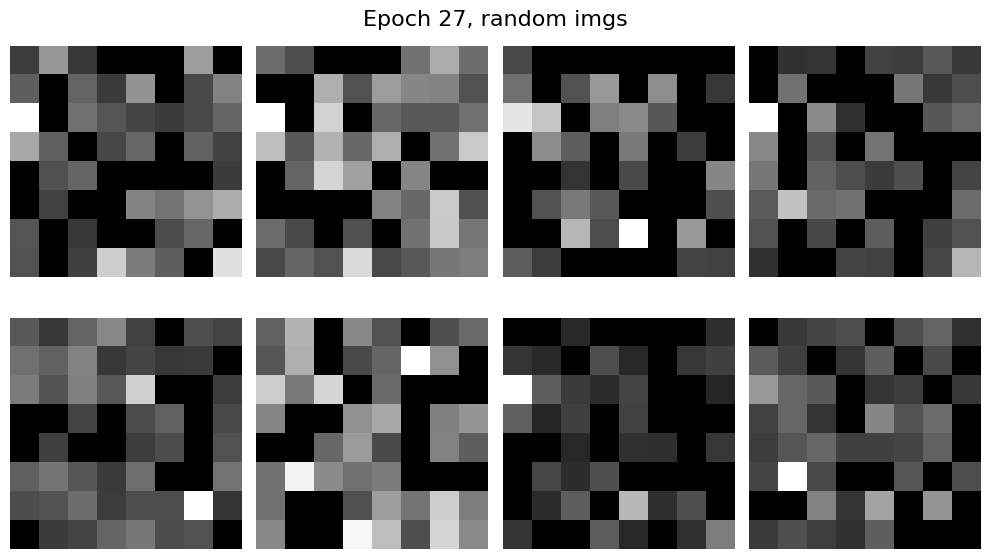

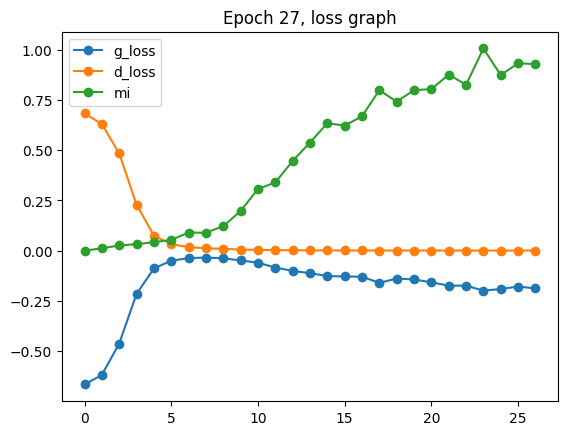

100%|██████████| 31/31 [01:12<00:00,  2.32s/it, G_loss=-.203, D_loss=0.000295, MI=0.984]


epoch: 28, D_loss: 0.00029454848704664336, G_loss: -0.20258823902376236, MI = 0.9836185805259212
a_loss: -12.560470819473267, b_loss: 19.88710254117019


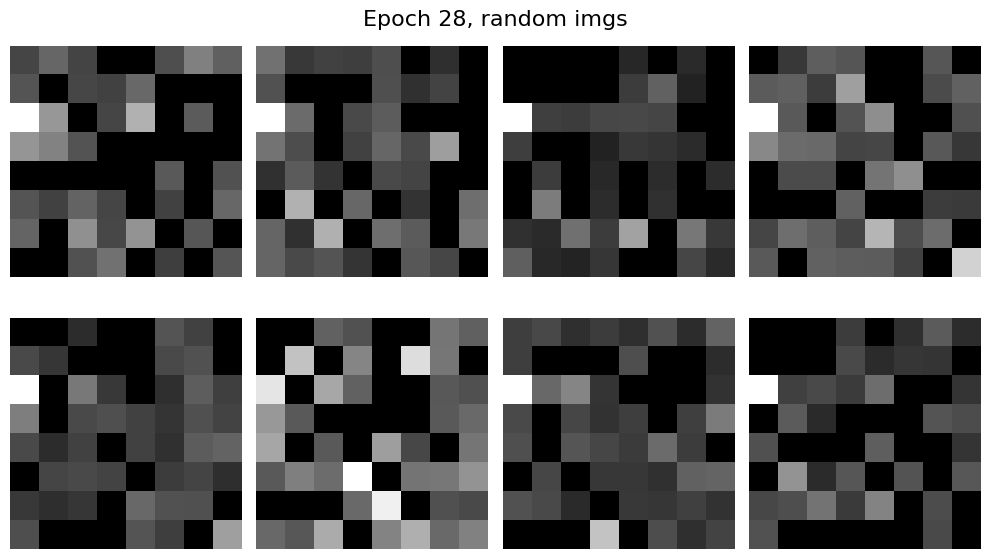

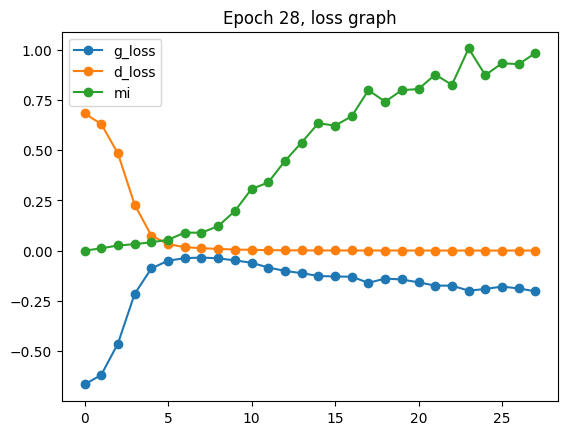

100%|██████████| 31/31 [01:10<00:00,  2.29s/it, G_loss=-.196, D_loss=0.000267, MI=0.925]

epoch: 29, D_loss: 0.0002671963687340218, G_loss: -0.19621063768863678, MI = 0.9247055245983985
a_loss: -12.16505953669548, b_loss: 18.917533333310814


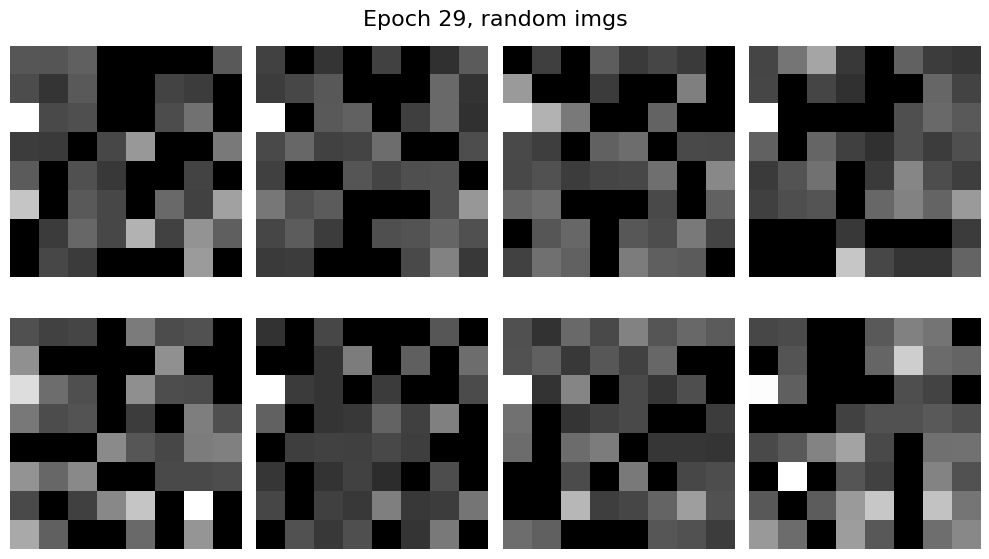

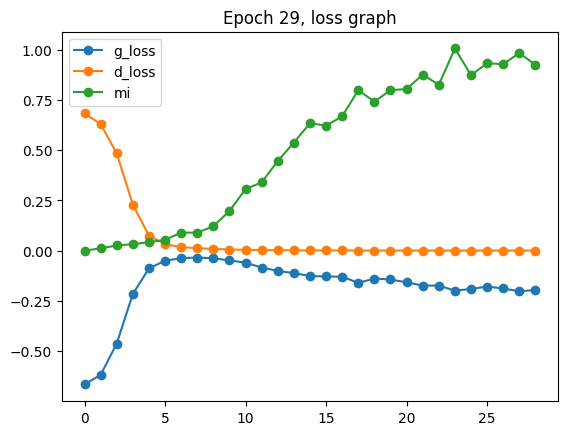

100%|██████████| 31/31 [01:10<00:00,  2.29s/it, G_loss=-.176, D_loss=0.0003, MI=0.938]  

epoch: 30, D_loss: 0.0002997982099318066, G_loss: -0.17619691344518815, MI = 0.9375799509786791
a_loss: -10.924208633601665, b_loss: 18.502231571828304


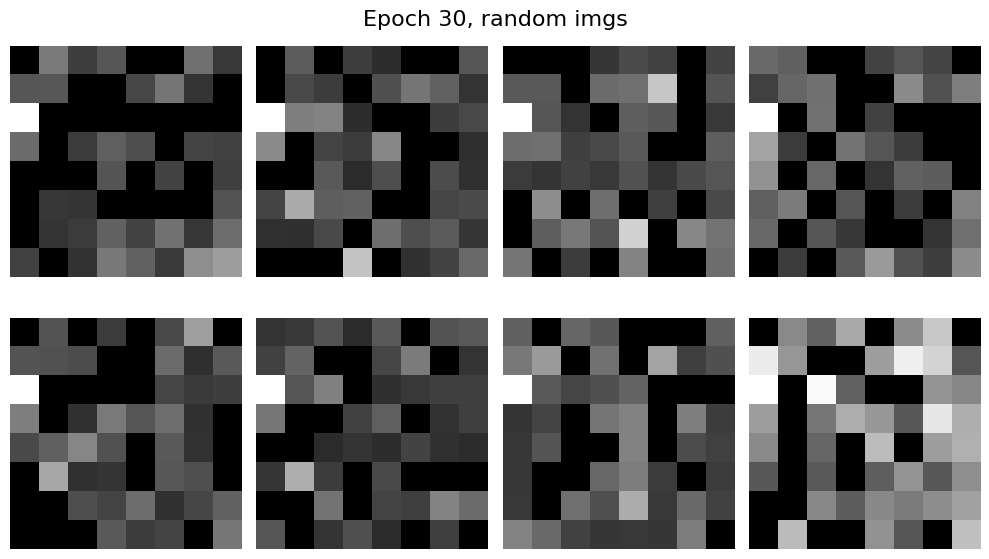

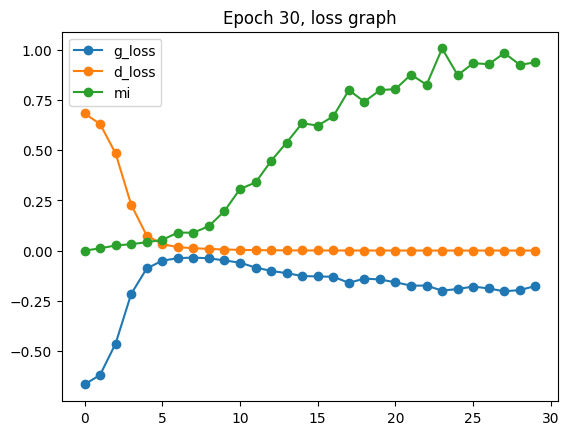

100%|██████████| 31/31 [01:13<00:00,  2.39s/it, G_loss=-.181, D_loss=0.000293, MI=1.03] 

epoch: 31, D_loss: 0.00029277608419145125, G_loss: -0.18070909212673864, MI = 1.0279914438724518
a_loss: -11.203963711857796, b_loss: 18.78190488415925


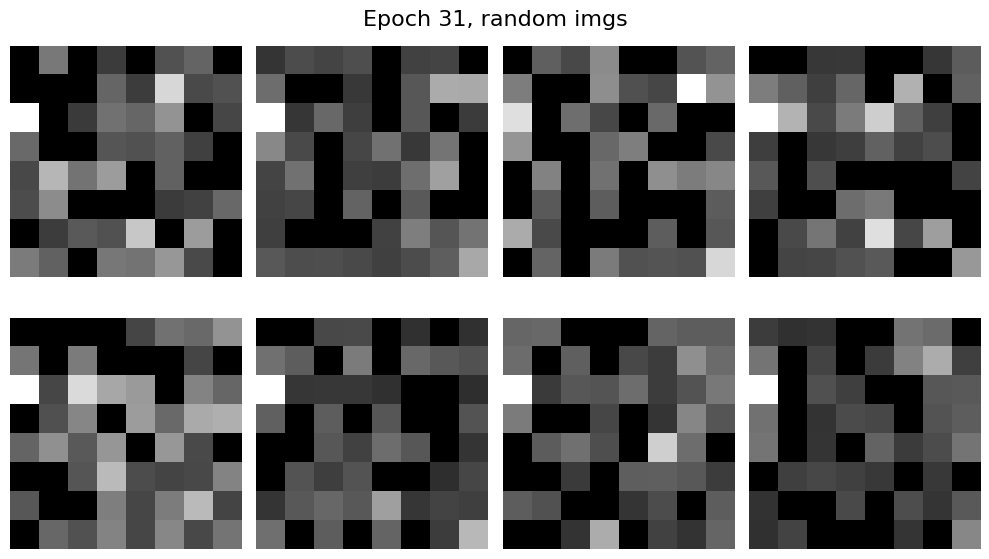

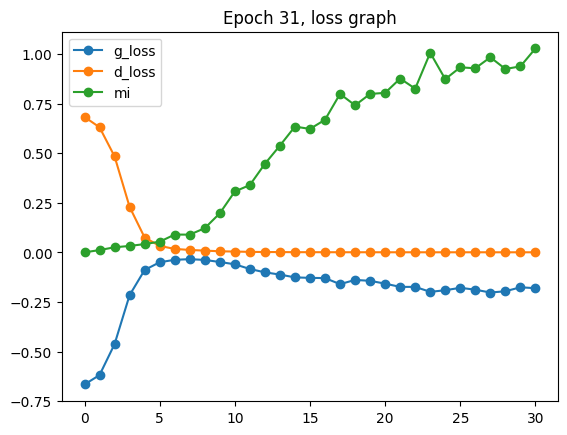

100%|██████████| 31/31 [01:12<00:00,  2.33s/it, G_loss=-.207, D_loss=0.000257, MI=1.01] 

epoch: 32, D_loss: 0.0002570842102173746, G_loss: -0.20675968979635545, MI = 1.0134267614733787
a_loss: -12.819100767374039, b_loss: 18.41039149119376


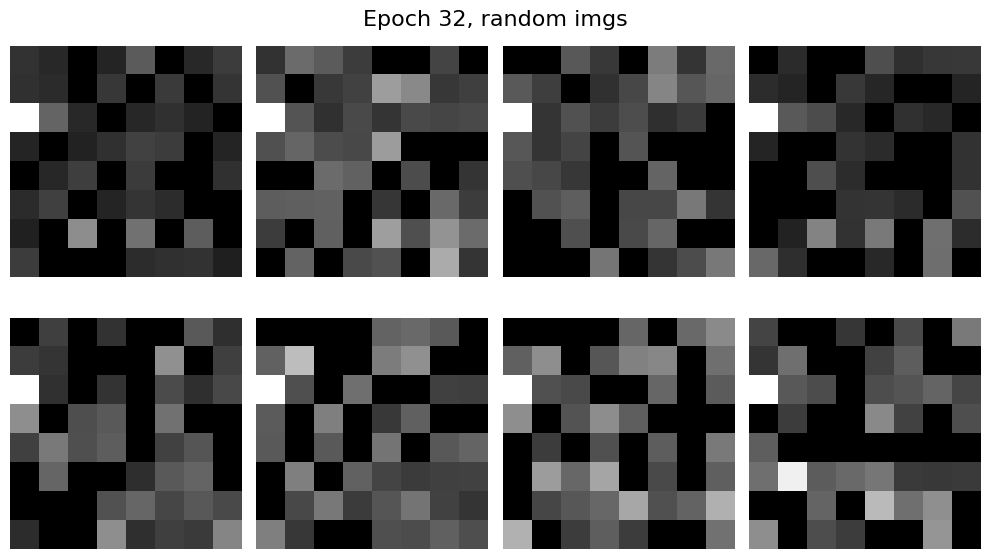

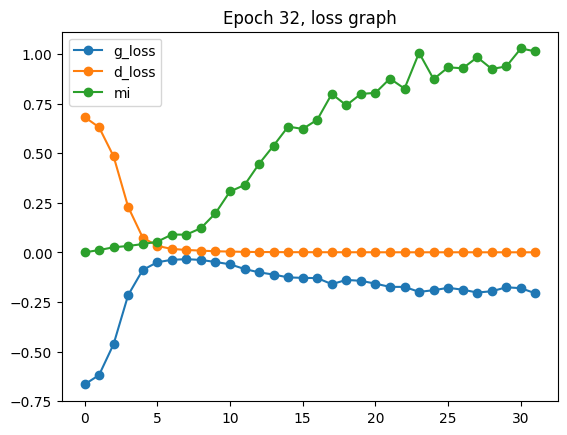

100%|██████████| 31/31 [01:12<00:00,  2.34s/it, G_loss=-.213, D_loss=0.000203, MI=0.951]

epoch: 33, D_loss: 0.00020299334174788167, G_loss: -0.21340433556225993, MI = 0.9514385682921256
a_loss: -13.231068804860115, b_loss: 18.95930741710619


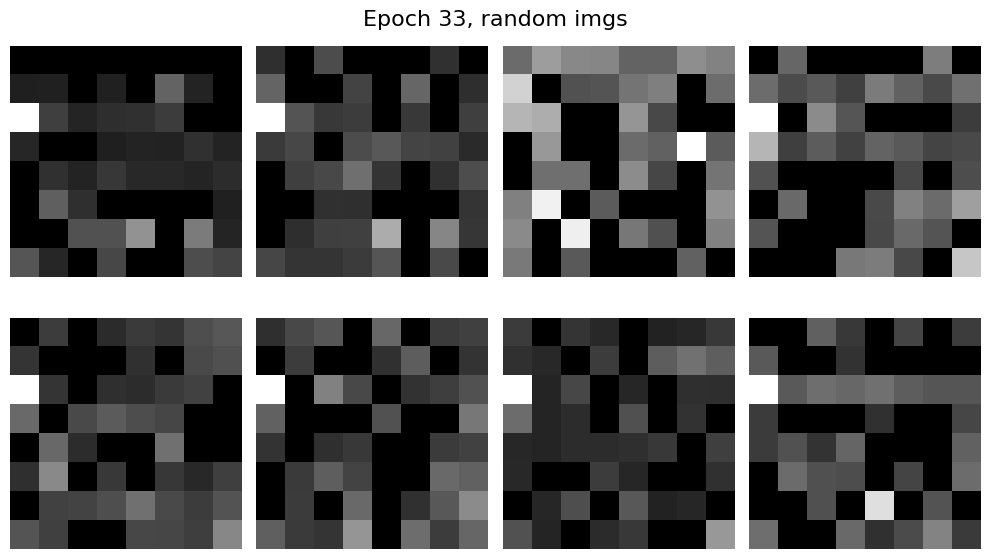

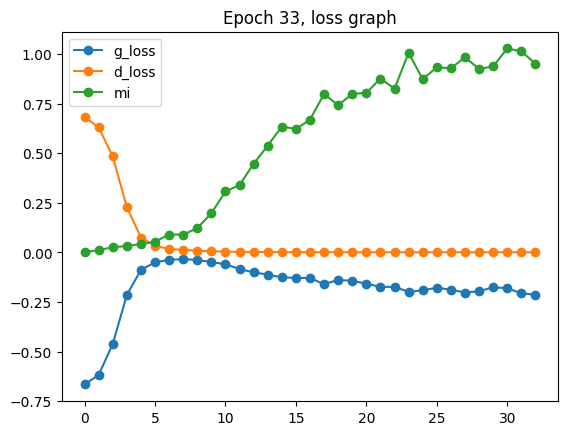

100%|██████████| 31/31 [01:12<00:00,  2.35s/it, G_loss=-.198, D_loss=0.000223, MI=1.18]

epoch: 34, D_loss: 0.00022331252201242494, G_loss: -0.1977085139482252, MI = 1.1799620505302184
a_loss: -12.257927864789963, b_loss: 18.439931472330947


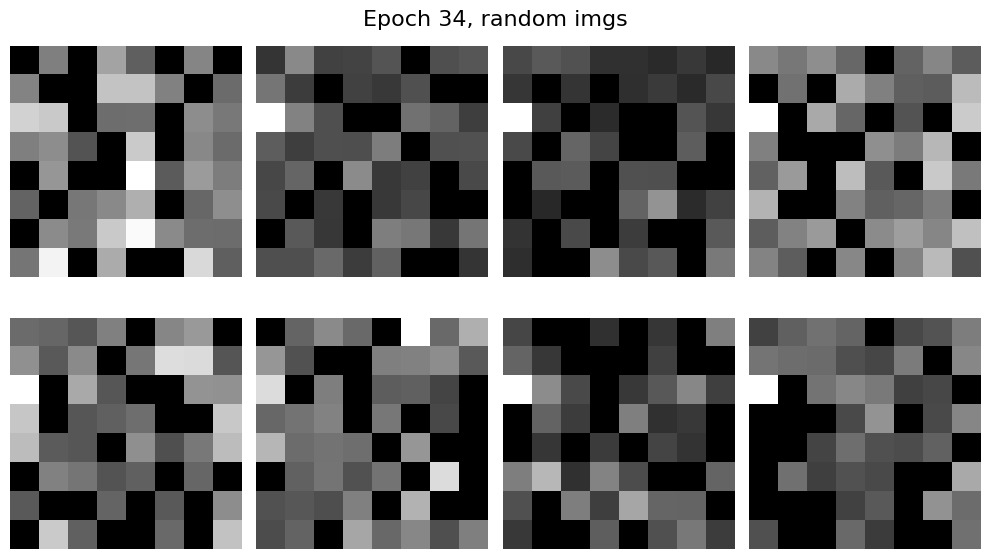

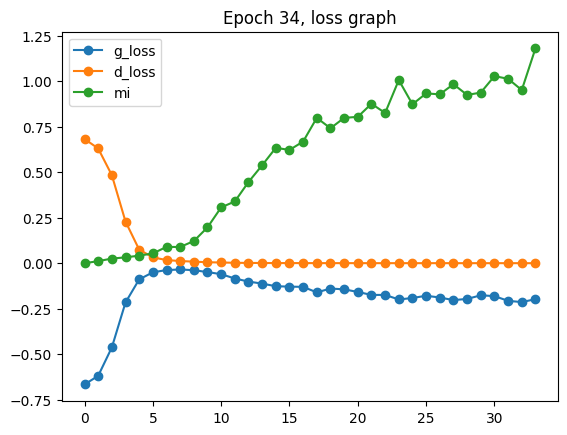

100%|██████████| 31/31 [01:09<00:00,  2.23s/it, G_loss=-.221, D_loss=0.000171, MI=1.14]

epoch: 35, D_loss: 0.00017133373518346719, G_loss: -0.22058916788908742, MI = 1.1434310674667358
a_loss: -13.67652840912342, b_loss: 18.435018887650774


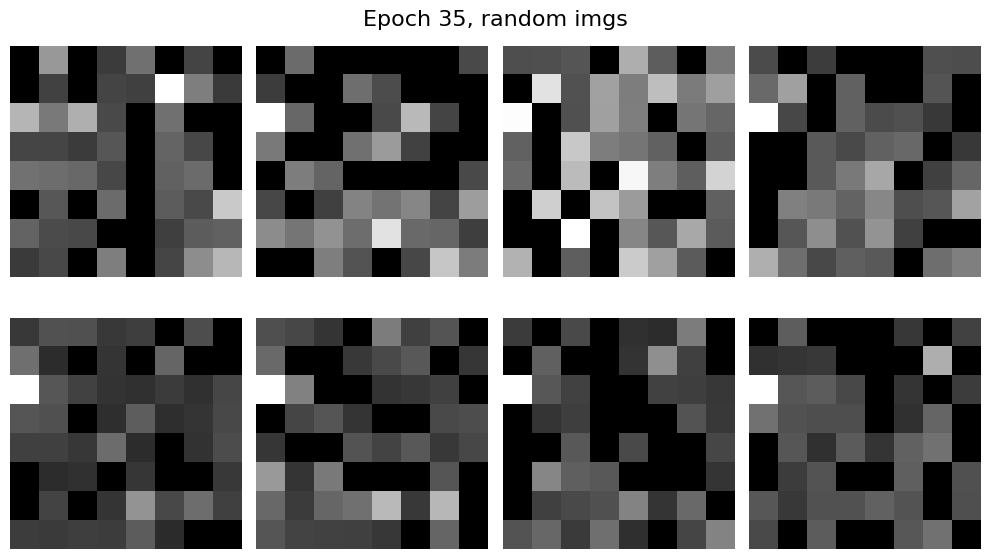

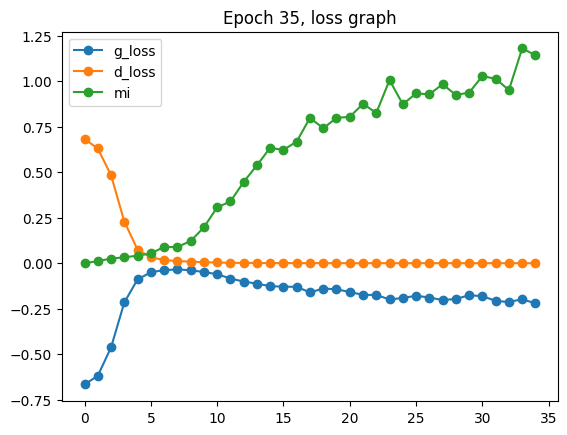

 32%|███▏      | 10/31 [00:26<00:56,  2.67s/it, G_loss=-.216, D_loss=0.000206, MI=1.17]


KeyboardInterrupt: 

In [277]:
epoch = 300

recorder_keywords = ['d_loss', 'g_loss', 'a_loss', 'b_loss', 'mi']
recorder = {k: [] for k in recorder_keywords}
final_rep = 0

for rep in range(1, epoch+1):
    np.random.shuffle(x_train)
    iter_num = int(len(x_train) * 0.5 //BATCH_SIZE) # 매번 50% 추출해서 학습. 셔플하니까 자투리 생기는건 무시.
    
    G_loss_sum = 0.0
    D_loss_sum = 0.0
    a_loss_sum = 0.0
    b_loss_sum = 0.0
    mi_sum = 0.0
    log_gen_outputs = []
    log_gen_codes = []
    pbar = tqdm(range(iter_num))
    
    for i in pbar:
        batch = torch.FloatTensor(x_train[BATCH_SIZE * i : BATCH_SIZE * i + BATCH_SIZE])
        
        # train generator
        generator_seed = torch.rand((BATCH_SIZE, n_qubits)) * 2 - 1
        generator_output, generator_loss, a, b = generator_train_step(generator_params, generator_seed, use_mine=use_mine, _qmine=use_qmine)
        G_opt.zero_grad()
        generator_loss.requires_grad_(True)
        generator_loss.backward()
        G_opt.step()
        a_loss_sum += a.detach().numpy()
        b_loss_sum += b.detach().numpy()

        # train discriminator
        fake_input = generator_output.detach().to(torch.float32)
        disc_loss = disc_cost_fn(batch.reshape(-1, 64), fake_input, smoothing=False)
        D_opt.zero_grad()
        disc_loss.requires_grad_(True)
        disc_loss.backward()
        D_opt.step()

        # train mine
        code_input = generator_seed[:, -code_qubits:] 
        pred_xy = mine(code_input, fake_input)
        code_input_shuffle = code_input[torch.randperm(BATCH_SIZE)]
        pred_x_y = mine(code_input_shuffle, fake_input)
        mi = -torch.mean(pred_xy) + torch.log(torch.mean(torch.exp(pred_x_y)))
        M_opt.zero_grad()
        mi.requires_grad_(True)
        mi.backward()
        M_opt.step()


        D_loss_sum += disc_loss.item()
        G_loss_sum += generator_loss.item()
        mi_sum -= mi.item() # (-1)곱해져 있어서 빼야함.
        a_loss_sum += a.item()
        b_loss_sum += b.item()

        pbar.set_postfix({'G_loss': G_loss_sum/(i+1), 'D_loss': D_loss_sum/(i+1), 'MI': mi_sum/(i+1)})
        log_gen_outputs.append(fake_input.numpy())
        log_gen_codes.append(code_input.numpy())

    G_scheduler.step()
    D_scheduler.step()
    M_scheduler.step()

    recorder['d_loss'].append(D_loss_sum/iter_num)
    recorder['g_loss'].append(G_loss_sum/iter_num)
    recorder['a_loss'].append(a_loss_sum/iter_num)
    recorder['b_loss'].append(b_loss_sum/iter_num)
    recorder['mi'].append(mi_sum/iter_num)
    
    log_gen_outputs = np.concatenate(log_gen_outputs, axis=0)
    log_gen_codes = np.concatenate(log_gen_codes, axis=0)
    print("epoch: {}, D_loss: {}, G_loss: {}, MI = {}".format(rep, D_loss_sum/iter_num, G_loss_sum/iter_num, mi_sum/iter_num))
    print("a_loss: {}, b_loss: {}".format(a_loss_sum, b_loss_sum))

    visualize_output(log_gen_outputs, log_gen_codes, title, rep, recorder)

    with open(f'result/{title}/savepoints/discriminator_{rep}.pkl', 'wb') as file:
        pickle.dump(discriminator, file)
    with open(f'result/{title}/savepoints/generator_{rep}.pkl', 'wb') as file:
        pickle.dump(generator_params, file)

    final_rep = rep

In [200]:
x = [generator_circuit(generator_params, np.random.uniform(-1, 1, n_qubits))[:64] for _ in range(16)]
x = torch.stack(x)
x[0]

tensor([9.8341e-03, 1.1695e-02, 4.1333e-03, 1.4365e-02, 8.0605e-03, 1.0435e-02,
        5.0681e-03, 9.2996e-03, 1.4729e-02, 5.0235e-03, 3.8366e-03, 1.0096e-04,
        1.3821e-02, 2.2044e-05, 7.7629e-03, 7.1025e-03, 3.9186e-04, 7.4211e-03,
        1.4278e-02, 5.7225e-03, 2.4611e-02, 1.3803e-02, 2.0611e-03, 6.6051e-03,
        2.4462e-02, 1.4816e-03, 3.5212e-02, 1.0904e-03, 8.4771e-03, 2.4930e-03,
        8.5806e-03, 2.1845e-05, 1.0841e-02, 1.1181e-02, 1.4807e-03, 2.1462e-03,
        1.4317e-04, 7.4140e-04, 2.3869e-03, 3.1764e-03, 1.7262e-03, 1.3703e-02,
        2.5732e-03, 3.3149e-03, 1.1073e-02, 8.1149e-03, 3.4928e-03, 1.2039e-02,
        1.2150e-02, 5.1965e-03, 9.3227e-04, 3.8483e-03, 1.0284e-03, 6.0628e-03,
        2.2836e-04, 4.4812e-04, 2.4957e-03, 1.7951e-02, 8.6424e-03, 2.8975e-02,
        1.5013e-02, 1.6382e-04, 9.8589e-03, 8.0573e-03], dtype=torch.float64,
       grad_fn=<SelectBackward0>)

In [201]:
x = x / x.max(dim=1, keepdim=True)[0]

In [125]:
x_train[3].max()

tensor(0.69534314, requires_grad=True)

In [128]:
import numpy as np

# (1000, 8, 8) shape의 이미지 리스트
image_list = np.random.random((1000, 8, 8))  # 예시로 랜덤한 이미지 생성

# 이미지 정규화 (픽셀 최대값을 1로 만들기)
normalized_images = image_list / np.max(image_list)

# 결과 확인
print("Original image max:", np.max(image_list[0]))
print("Normalized image max:", np.max(normalized_images[0]))

Original image max: 0.9168166456652552
Normalized image max: 0.9168166828219565


In [138]:
x_train = x_train / np.max(x_train, axis=(1, 2), keepdims=True)

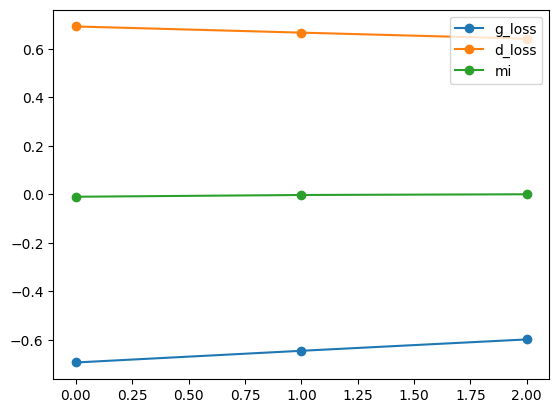

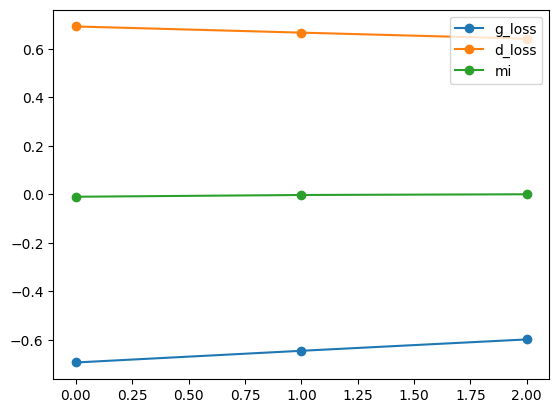

In [222]:
plt.figure()
plt.plot(recorder['g_loss'], label='g_loss', marker='o')
plt.plot(recorder['d_loss'], label='d_loss', marker='o')
plt.plot(recorder['mi'], label='mi', marker='o')
plt.legend()
plt.show()

plt.figure()
plt.plot(recorder['g_loss'], label='g_loss', marker='o')
plt.plot(recorder['d_loss'], label='d_loss', marker='o')
plt.plot(recorder['mi'], label='mi', marker='o')
plt.legend()
plt.show()